Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=63
num_BackTrack_Days=6

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  10/26/21  10/27/21  10/28/21  \
185        0        0        0        0  ...       460       460       460   
186        0        0        0        0  ...         0         0         0   
187        0        0        0        0  ...       792       792       794   
188        0        0        0        0  ...       160       160       164   
189        0        0        0        0  ...    286496    286888    287631   
190        0        0        0        0  ...         0         0         0   
191        0        0        0        0  ...      7576      7619      7665   
192        0        0        0        0  ...        36        36        36   
193        0        0        0        0  ...      1689      1699      1711   
194        0        0        0        0  ...      2075      2082      2087   

     10/29/21  10/30/21  10/31/21  11/1/21  11/2/21   Population   \
185       461       461       461      461      462       441,543   
186         0         0         0        0        0           NaN   
187       794       795       797      797      798     4,649,658   
188       166       166       166      176      176     1,273,985   
189    287951    288276    288365   288365   288464   128,640,794   
190         0         0         0        0        0           NaN   
191      7665      7751      7790     7828     7870     4,035,942   
192        36        36        36       36       36        39,183   
193      1722      1734      1745     1755     1767     3,278,290   
194      2095      2100      2103     2107     2113       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 657 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/26/21  \
175        0        0        0        0        0        0  ...         0   
176        0        0        0        0        0        0  ...         0   
177        0        0        0        0        0        0  ...         0   
178        0        0        0        0        0        0  ...         0   
179        0        0        0        0        0        0  ...         0   
180        0        0        0        0        0        0  ...         0   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...         0   

     10/27/21  10/28/21  10/29/21  10/30/21  10/31/21  11/1/21  11/2/21  \
175         0         0         0         0         0        0        0   
176         0         0         0         0         0        0        0   
177         0         0         0         0         0        0        0   
178         0         0         0         0         0        0        0   
179         0         0         0         0         0        0        0   
180         0         0         0         0         0        0        0   
181         0         0         0         0         0        0        0   
182         0         0         0         0         0        0        0   
183         0         0         0         0         0        0        0   
184         0         0         0         0         0        0        0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 657 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  10/26/21  10/27/21  10/28/21  \
185        0        0        0        0  ...     37580     37595     37610   
186        0        0        0        0  ...         4         4         4   
187        0        0        0        0  ...     37032     37094     37155   
188        0        0        0        0  ...     17416     17416     17586   
189        0        0        0        0  ...   3784448   3788986   3798286   
190        0        0        0        0  ...         1         1         1   
191        0        0        0        0  ...    330799    332625    334287   
192        0        0        0        0  ...      3399      3399      3407   
193        0        0        0        0  ...    353504    355129    356765   
194        0        0        0        0  ...    141834    142308    142807   

     10/29/21  10/30/21  10/31/21  11/1/21  11/2/21   Population   \
185     37618     37637     37653    37673    37702       441,543   
186         4         4         4        4        4           NaN   
187     37222     37275     37320    37368    37435     4,649,658   
188     17698     17698     17698    17812    17812     1,273,985   
189   3802287   3805765   3807211  3807211  3808205   128,640,794   
190         1         1         1        1        1           NaN   
191    335860    337115    337768   339114   340188     4,035,942   
192      3414      3414      3414     3414     3414        39,183   
193    358208    359396    360317   361338   362772     3,278,290   
194    143322    143785    144314   144692   145314       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 657 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/26/21  \
220        0        0        0        0        0        0  ...   1086280   
221        0        0        0        0        0        0  ...    238742   
222        0        0        0        0        0        0  ...   1587880   
223        0        0        0        0        0        0  ...   8185400   
224        0        0        0        0        0        0  ...     99474   
225        0        0        0        0        0        0  ...      2637   
226        0        0        0        0        0        0  ...     12465   
227        0        0        0        0        0        0  ...      4860   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      5521   

     10/27/21  10/28/21  10/29/21  10/30/21  10/31/21  11/1/21  11/2/21  \
220   1087245   1088133   1088977   1089888   1090651  1091142  1091592   
221    238845    238950    239051    239143    239247   239374   239508   
222   1602830   1616027   1628501   1640607   1648031  1655024  1666097   
223   8220975   8260045   8298850   8338053   8377984  8417305  8455232   
224     99514     99565     99628     99681     99698    99727    99765   
225      2657      2664      2668      2669      2669     2675     2686   
226     12486     12517     12536     12559     12559    12573    12586   
227      4905      4941      4951      4951      4995     4995     5012   
228         3         3         3         3         3        3        3   
229      5534      5540      5547      5547      5547     5547     5547   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 657 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

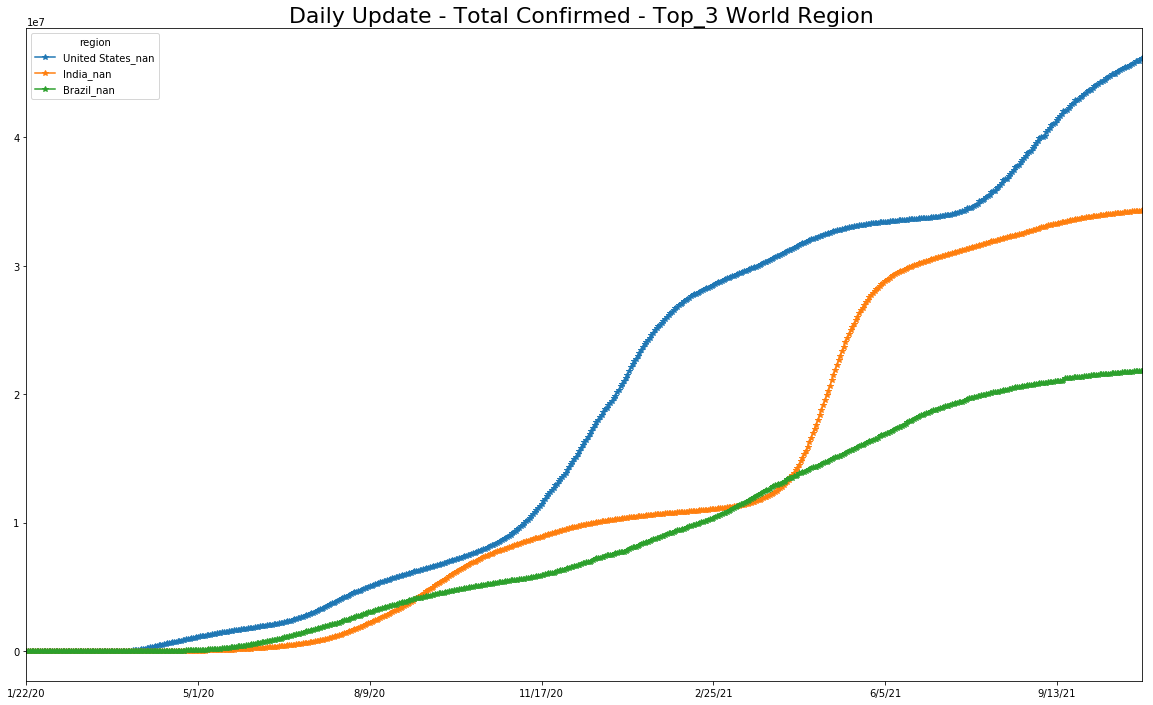

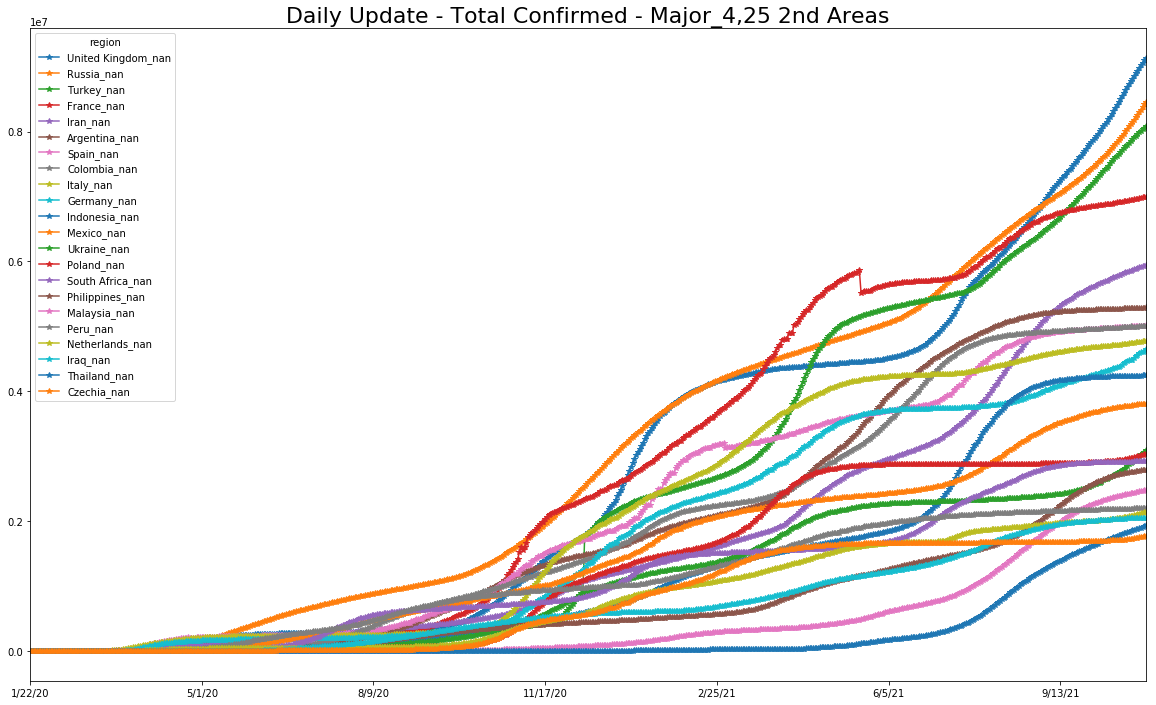

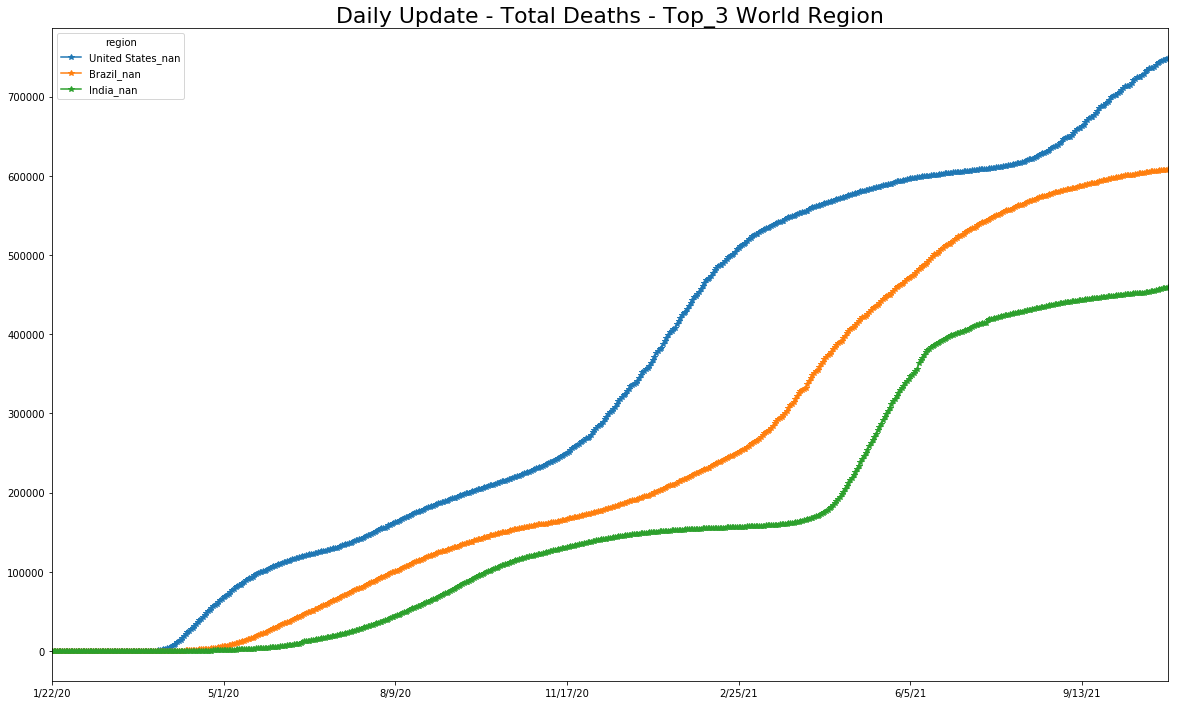

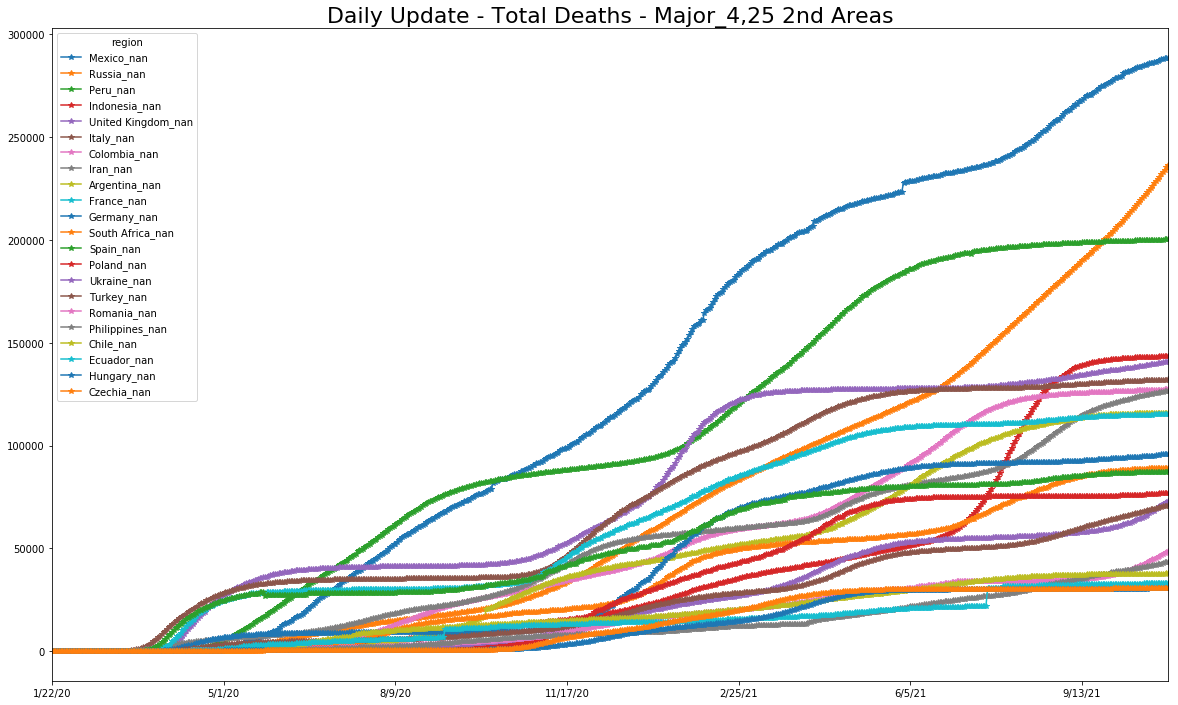

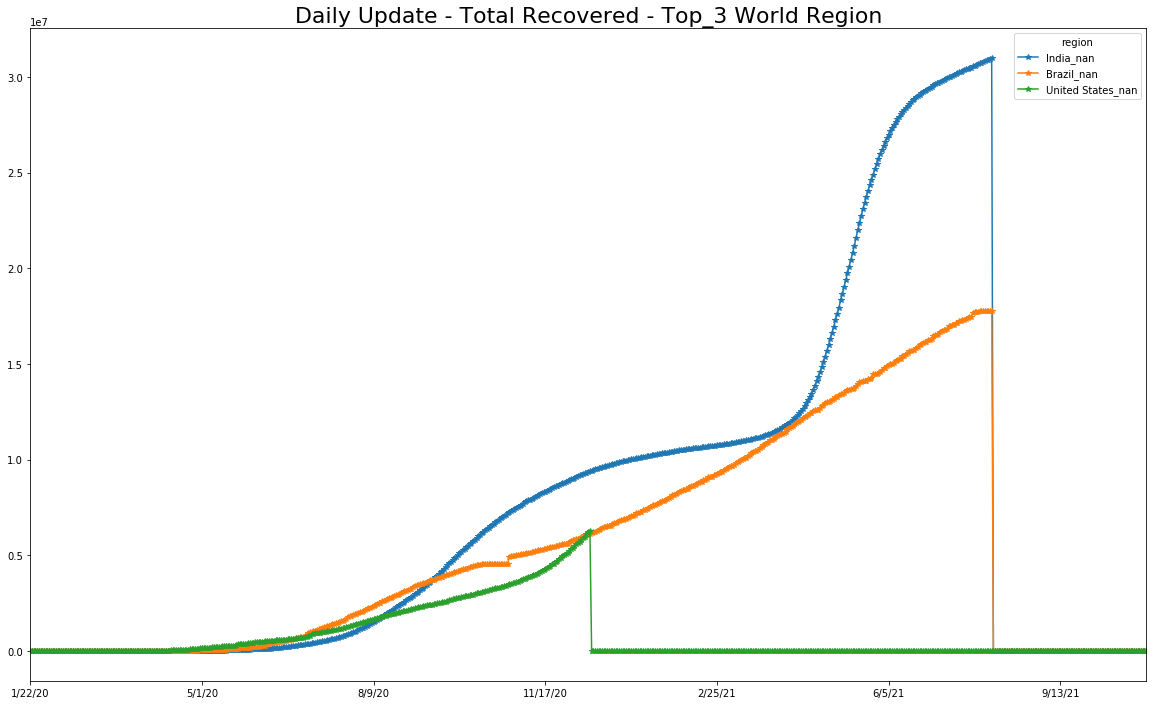

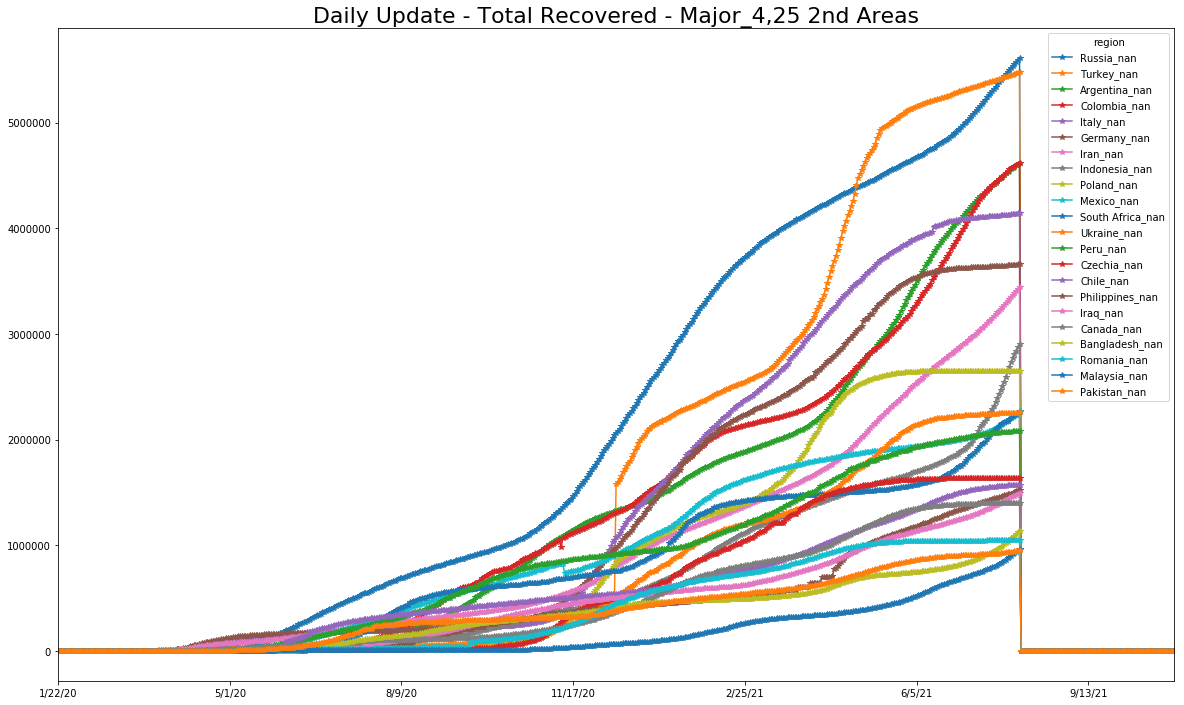

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/11/03


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31414638       149430           85291            3   
4/14/21  ...           31490292       152089           85503            3   
4/15/21  ...           31564290       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
10/30/21           156210       184887       206358        15516       64374   
10/31/21           156250       185300       206452        15516       64433   
11/1/21            156284       185497       206566        15516       64458   
11/2/21            156307       186222       206649        15516       64487   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
10/30/21                     4058        5288259       306739   
10/31/21                     4058        5288807       308326   
11/1/21                      4062        5289945       309397   
11/2/21                      4069        5291285       310629   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
10/30/21                                    1775                      75278   
10/31/21                                    1780                      75407   
11/1/21                                     1788                      75578   
11/2/21                                     1803                      75766   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
10/30/21  ...           45953186       393718          185647            6   
10/31/21  ...           45970785       393899          185963            6   
11/1/21   ...           46096258       394053          186244            6   
11/2/21   ...           46169012       394248          186793            6   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
10/30/21         406239       915603                  452997       9779   
10/31/21         407151       921122                  452997       9791   
11/1/21          407866       926720                  453782       9799   
11/2/21          408727       932357                  454172       9806   

region    Zambia_nan  Zimbabwe_nan  
10/30/21      209722        132926  
10/31/21      209734        132977  
11/1/21       209739        133007  
11/2/21       209760        133047  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
58600 2021-10-05     Zimbabwe_nan     131205             0           101   
58601 2021-10-06     Zimbabwe_nan     131434            76           111   
58602 2021-10-07     Zimbabwe_nan     131523           229           305   
58603 2021-10-08     Zimbabwe_nan     131705            89           394   
58604 2021-10-09     Zimbabwe_nan     131762           182           500   
58605 2021-10-10     Zimbabwe_nan     131796            57           328   
58606 2021-10-11     Zimbabwe_nan     131875            34           273   
58607 2021-10-12     Zimbabwe_nan     132016            79           170   
58608 2021-10-13     Zimbabwe_nan     132108           141           254   
58609 2021-10-14     Zimbabwe_nan     132251            92           312   
58610 2021-10-15     Zimbabwe_nan     132285           143           376   
58611 2021-10-16     Zimbabwe_nan     132333            34           269   
58612 2021-10-17     Zimbabwe_nan     132368            48           225   
58613 2021-10-18     Zimbabwe_nan     132368            35           117   
58614 2021-10-19     Zimbabwe_nan     132405             0            83   
58615 2021-10-20     Zimbabwe_nan     132437            37            72   
58616 2021-10-21     Zimbabwe_nan     132540            32            69   
58617 2021-10-22     Zimbabwe_nan     132588           103           172   
58618 2021-10-23     Zimbabwe_nan     132588            48           183   
58619 2021-10-24     Zimbabwe_nan     132651             0           151   
58620 2021-10-25     Zimbabwe_nan     132688            63  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
58629 2021-11-03  Zimbabwe_nan          0            40           121   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
58629           323         100.030081         100.091036          100.24337   

       last_day  kalman_prediction  population  infected_rate  min  max  
58629    133047           133095.0    14862924        0.00009  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
58629 2021-11-03  Zimbabwe_nan          0            40           121   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
58629           323         100.030081         100.091036          100.24337   

       last_day  kalman_prediction  population  infected_rate  min  max  
58629    133047           133095.0    14862924        0.00009  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
57397  2021-11-01  Zimbabwe_nan     133007            51            97   
57398  2021-11-02  Zimbabwe_nan     133047            30            81   
57399  2021-11-03  Zimbabwe_nan          0            40           121   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
57397           326         100.038375         100.073006         100.245765   
57398           319         100.022568         100.060944         100.240421   
57399           323         100.030081         100.091036         100.243370   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
57397               132977  ...    14862924       0.000089  NaN  NaN   
57398               133007  ...    14862924       0.000089  NaN  NaN   
57399               133047  ...    14862924       0.000090  NaN  NaN   

       population_percentage : infected_rate confirmed  \
57397                                         0.008947   
57398                                         0.008949   
57399                                         0.008952   

       population_percentage : factor 9/10 infected_rate confirmed  \
57397                                           0.080523             
57398                                           0.080541             
57399                                           0.080565             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
57397                    58.0                           3.902328   
57398                    56.0                           3.767765   
57399                    48.0                           3.229513   

       delta : roling 7day AVG  \
57397                46.571429   
57398                45.571429   
57399                46.142857   

       delta : aprox 14-day case notification rate per 100k hab  
57397                                           4.386755         
57398                                           4.292560         
57399                                           4.346386         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
270  United States_nan  1.060564e+13  3.256630e+06  292323.857843


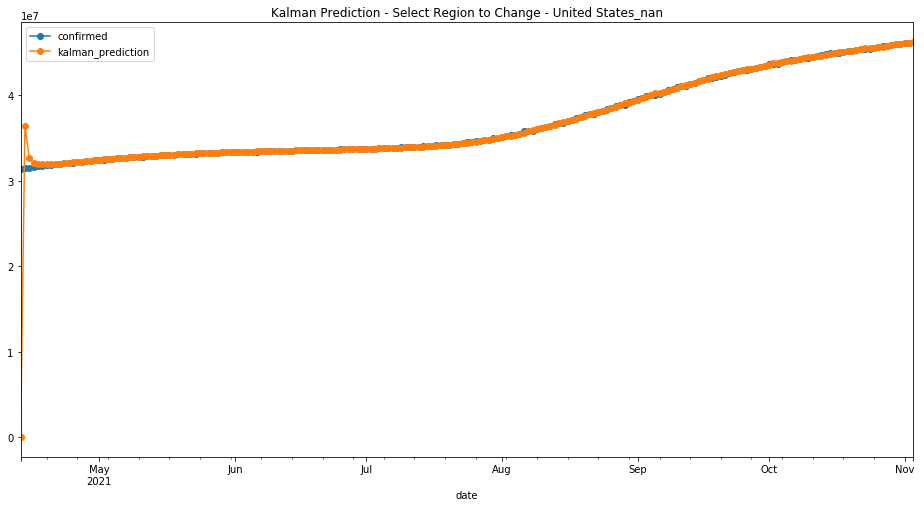

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  3.563790e+11  596974.853521  48486.313725


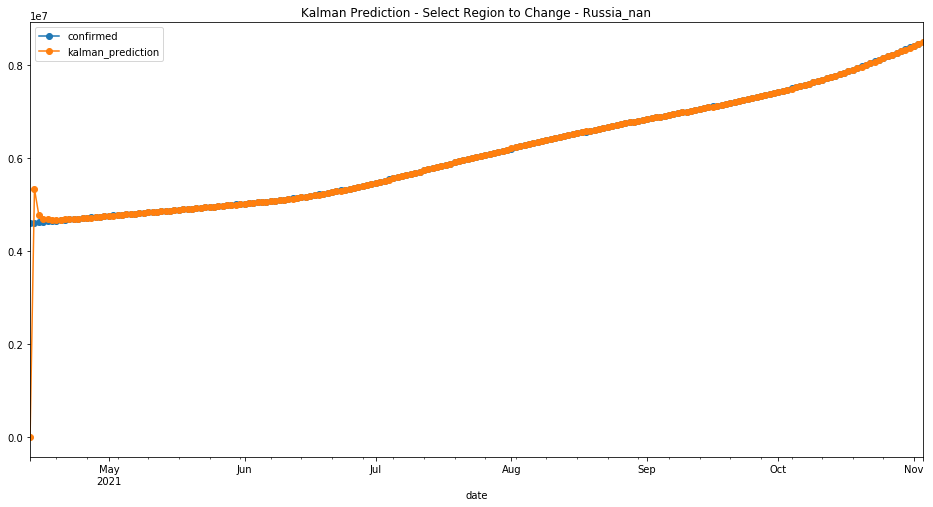

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.360447e+12  1.536375e+06  139462.009804


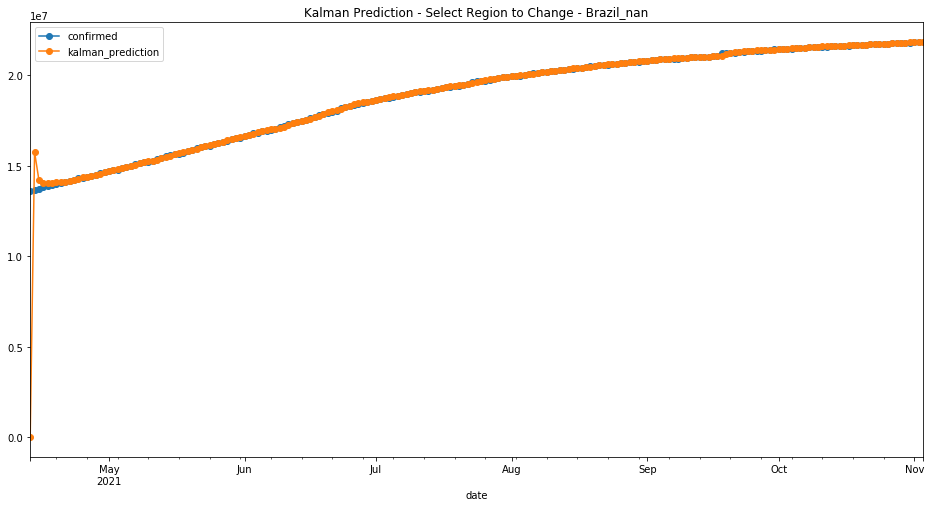

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
269  United Kingdom_nan  4.151170e+11  644295.764558  54639.867647


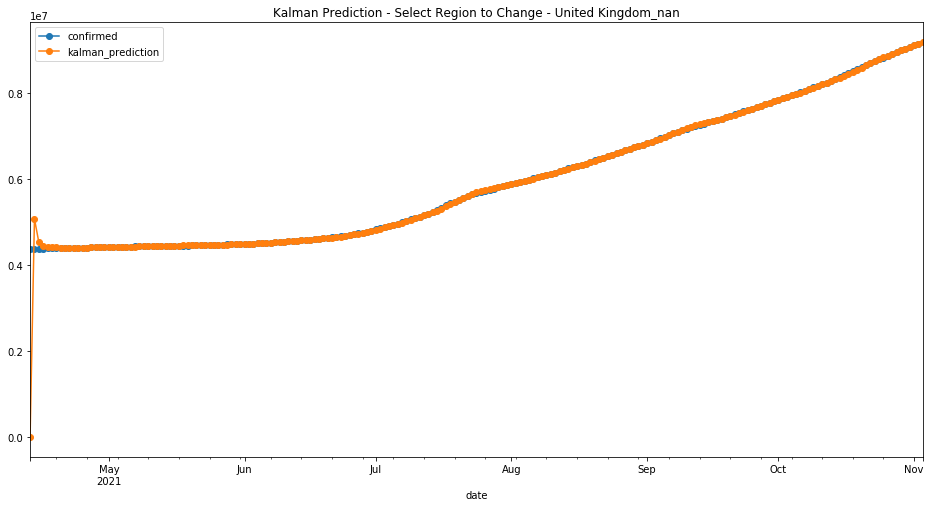

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy_zivxr6
  JVM stdout: /tmp/tmpy_zivxr6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpy_zivxr6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years and 7 days !!!
H2O cluster name:           H2O_from_python_unknownUser_mrz2dt
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-10-07
last_train_date= 2021-11-02
first_bootstrap_date= 2021-10-25
boost_bootstrap_date= 2021-10-30
first_test_date= 2021-10-24
last_test_date= 2021-11-03
first_valid_date= 2021-11-01


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   157138.0     156040 2021-10-25  Afghanistan_nan
1   157165.0     156071 2021-10-26  Afghanistan_nan
2   157238.0     156124 2021-10-27  Afghanistan_nan
3   157285.0     156166 2021-10-28  Afghanistan_nan
4   157338.0     156196 2021-10-29  Afghanistan_nan
5   157382.0     156210 2021-10-30  Afghanistan_nan
6   157410.0     156250 2021-10-31  Afghanistan_nan
7   157430.0     156284 2021-11-01  Afghanistan_nan
8   157462.0     156307 2021-11-02  Afghanistan_nan
9   157491.0          0 2021-11-03  Afghanistan_nan
10  182634.0     181960 2021-10-25      Albania_nan
11  183051.0     182610 2021-10-26      Albania_nan
12  183438.0     183282 2021-10-27      Albania_nan
13  184044.0     183873 2021-10-28      Albania_nan
14  184687.0     184340 2021-10-29      Albania_nan
15  185255.0     184887 2021-10-30      Albania_nan
16  185766.0     185300 2021-10-31      Albania_nan
17  186260.0     185497 2021-11-01      Albania_nan
18  186592.0     186222 2021-11-02      Albania_nan
19  186942.0          0 2021-11-03      Albania_nan
20  207014.0     205903 2021-10-25      Algeria_nan
21  207086.0     205990 2021-10-26      Algeria_nan
22  207167.0     206069 2021-10-27      Algeria_nan
23  207251.0     206160 2021-10-28      Algeria_nan
24  207336.0     206270 2021-10-29      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  529301.0     529109 2021-10-30  Azerbaijan_nan
176  531539.0     531370 2021-10-31  Azerbaijan_nan
177  533809.0     532570 2021-11-01  Azerbaijan_nan
178  535440.0     534748 2021-11-02  Azerbaijan_nan
179  537251.0          0 2021-11-03  Azerbaijan_nan
180   22955.0      22259 2021-10-25     Bahamas_nan
181   22703.0      22259 2021-10-26     Bahamas_nan
182   22972.0      22259 2021-10-27     Bahamas_nan
183   22962.0      22351 2021-10-28     Bahamas_nan
184   22703.0      22351 2021-10-29     Bahamas_nan
185   23030.0      22351 2021-10-30     Bahamas_nan
186   23036.0      22351 2021-10-31     Bahamas_nan
187   23020.0      22407 2021-11-01     Bahamas_nan
188   22869.0      22429 2021-11-02     Bahamas_nan
189   23014.0          0 2021-11-03     Bahamas_nan
190  275798.0     276608 2021-10-25     Bahrain_nan
191  275836.0     276635 2021-10-26     Bahrain_nan
192  275862.0     276685 2021-10-27     Bahrain_nan
193  275893.0     276718 2021-10-28     Bahrain_nan
194  275925.0     276749 2021-10-29     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   588474.0     588231 2021-10-25  Belarus_nan
221   590506.0     590226 2021-10-26  Belarus_nan
222   592509.0     592224 2021-10-27  Belarus_nan
223   594497.0     594203 2021-10-28  Belarus_nan
224   596467.0     596191 2021-10-29  Belarus_nan
225   598434.0     598183 2021-10-30  Belarus_nan
226   600405.0     600168 2021-10-31  Belarus_nan
227   602377.0     602058 2021-11-01  Belarus_nan
228   604290.0     604037 2021-11-02  Belarus_nan
229   606226.0          0 2021-11-03  Belarus_nan
230  1318913.0    1328202 2021-10-25  Belgium_nan
231  1329375.0    1333947 2021-10-26  Belgium_nan
232  1337082.0    1342718 2021-10-27  Belgium_nan
233  1346395.0    1351913 2021-10-28  Belgium_nan
234  1356327.0    1360650 2021-10-29  Belgium_nan
235  1366170.0    1360650 2021-10-30  Belgium_nan
236  1369760.0    1360650 2021-10-31  Belgium_nan
237  1370442.0    1360650 2021-11-01  Belgium_nan
238  1369188.0    1360650 2021-11-02  Belgium_nan
239  1367290.0          0 2021-11-03  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  107134686094.44447
# MSE on the validation data =  37758768814580.94
# R^2 on the training data =  0.9983407468013786
# R^2 on the validation data =  0.4199547646988503


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1635922407831_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 107134686094.44447
RMSE: 327314.3536333909
MAE: 17841.80515440121
RMSLE: 0.4999624818257511
Mean Residual Deviance: 107134686094.44447

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 37758768814580.94
RMSE: 6144816.418297697
MAE: 1659571.3340175857
RMSLE: 7.995641732724875
Mean Residual Deviance: 37758768814580.94
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2021-11-03 06:53:37  0.056 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2021-11-03 06:53:38  0.413 sec   1.0                768653.9539314056   80647.25417521219   590828900894.3833    6148201.864739335  1654016.5869862325  37800386169584.234
     2021-11-03 06:53:38  0.582 sec   2.0                702034.0632940823   61741.356822412694  492851826025.1995    6131404.514875842  1650056.5055377719  37594121325039.87
     2021-11-03 06:53:38  0.892 sec   3.0                595430.2556851462   49201.59821867676   354537189385.27856   6134074.043993221  1648532.773010403   37626864377191.34
     2021-11-03 06:53:39  1.216 sec   4.0                580854.4146225428   47308.548820348835  337391850986.4968    6136128.636576017  1647349.2033101502  37652074644608.26
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2021-11-03 06:53:45  8.093 sec   113.0              313468.1789153782   20067.086503127714  98262299192.52354    6150414.245942341  1663297.239330737   37827595396690.49
     2021-11-03 06:53:49  12.113 sec  213.0              317845.54090984387  19472.28775377973   101025787876.27122   6152471.183257571  1666039.084334614   37852901660814.82
     2021-11-03 06:53:53  16.131 sec  310.0              328015.47248774435  18802.361289020177  107594150191.35817   6150406.885434344  1663692.7849147613  37827504856398.195
     2021-11-03 06:53:57  20.162 sec  402.0              324335.5337249782   17997.443131775522  105193538436.66647   6147424.37677403   1661452.221458788   37790826468155.57
     2021-11-03 06:54:02  25.027 sec  500.0              327314.3536333909   17841.80515440121   107134686094.44447   6144816.418297697  1659571.3340175857  37758768814580.94


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  8.65108e+19            1                    0.37126
last_day           6.54993e+19            0.757123             0.28109
region             4.40243e+19            0.508888             0.18893
7_day_change       1.5295e+19             0.176799             0.0656385
3_day_change       1.01064e+19            0.116822             0.0433714
1_day_change       5.77272e+18            0.0667283            0.0247736
infected_rate      2.92202e+18            0.0337763            0.0125398
7_day_change_rate  1.5698e+18             0.0181458            0.0067368
3_day_change_rate  7.74432e+17            0.00895185           0.00332347
1_day_change_rate  5.44356e+17            0.00629235           0.0023361

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         8.651080e+19           1.000000    0.371260
1           last_day         6.549933e+19           0.757123    0.281090
2             region         4.402427e+19           0.508888    0.188930
3       7_day_change         1.529504e+19           0.176799    0.065639
4       3_day_change         1.010638e+19           0.116822    0.043371
5       1_day_change         5.772721e+18           0.066728    0.024774
6      infected_rate         2.922015e+18           0.033776    0.012540
7  7_day_change_rate         1.569804e+18           0.018146    0.006737
8  3_day_change_rate         7.744316e+17           0.008952    0.003323
9  1_day_change_rate         5.443564e+17           0.006292    0.002336

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


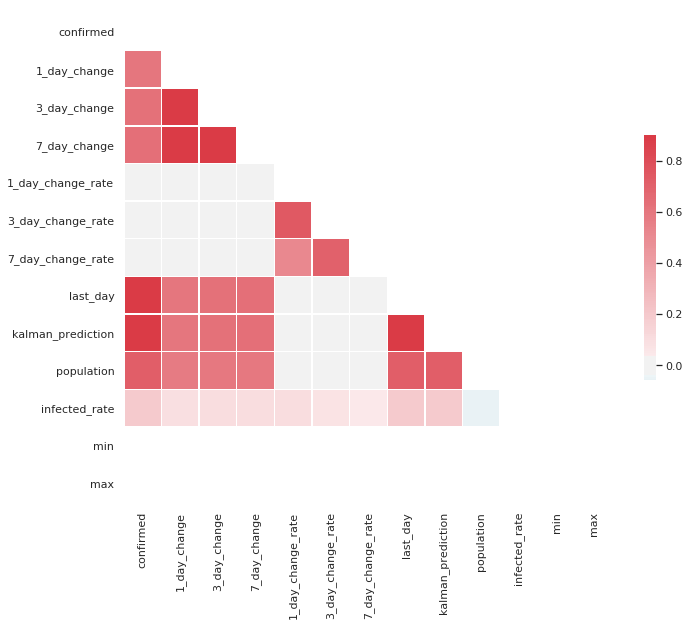

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.607218
3_day_change         0.626995
7_day_change         0.636107
1_day_change_rate    0.019387
3_day_change_rate    0.012878
7_day_change_rate    0.005483
last_day             0.993603
kalman_prediction    0.994928
population           0.718045
infected_rate        0.191035
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


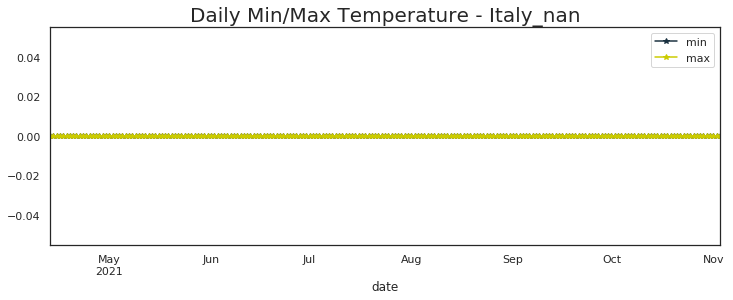

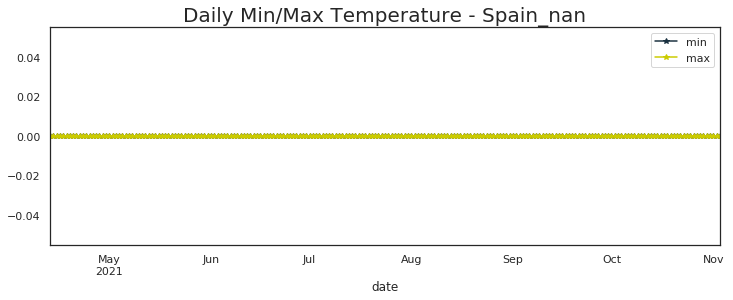

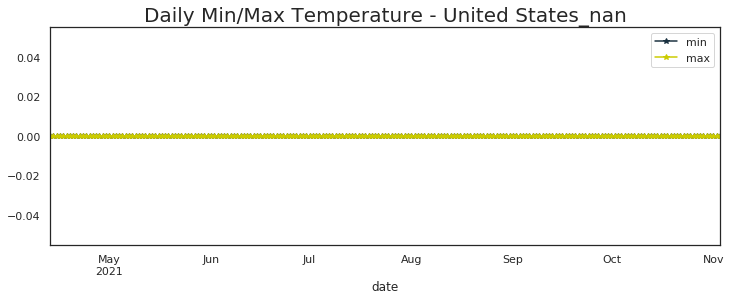

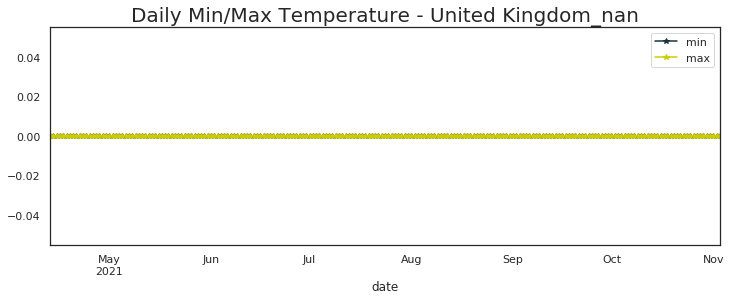

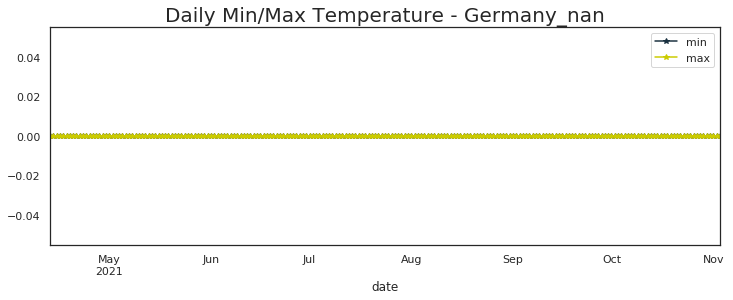

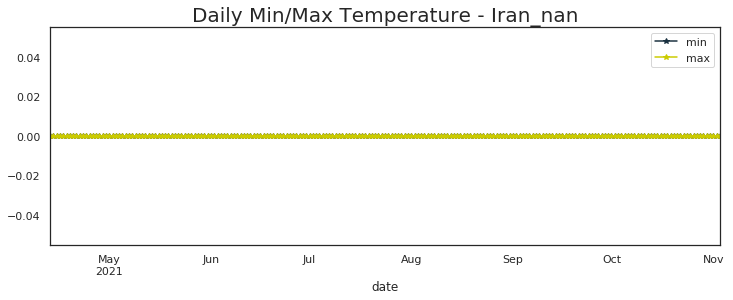

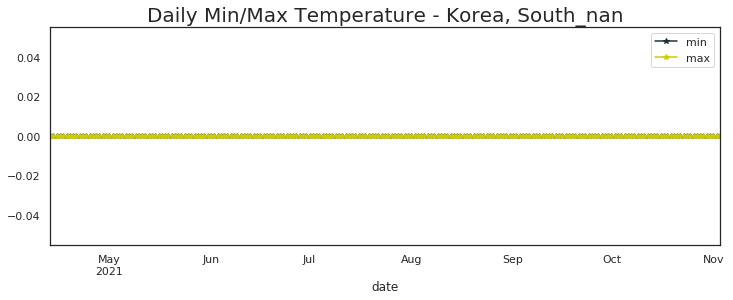

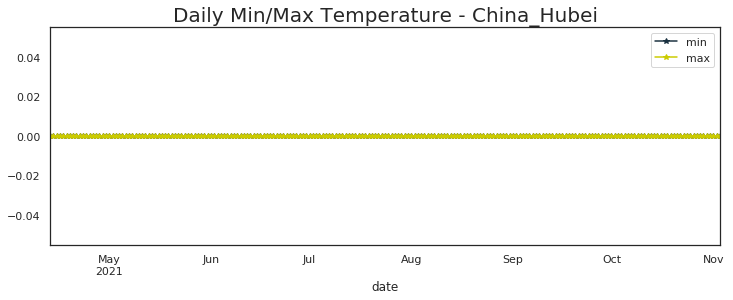

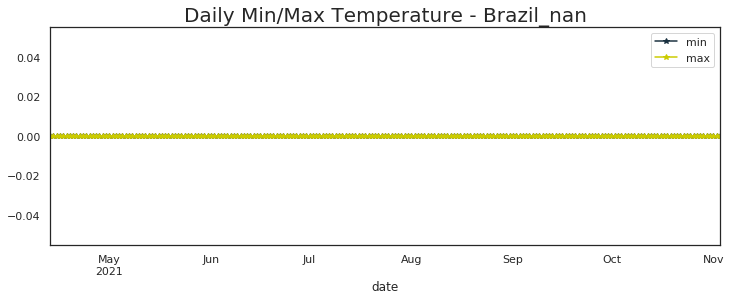

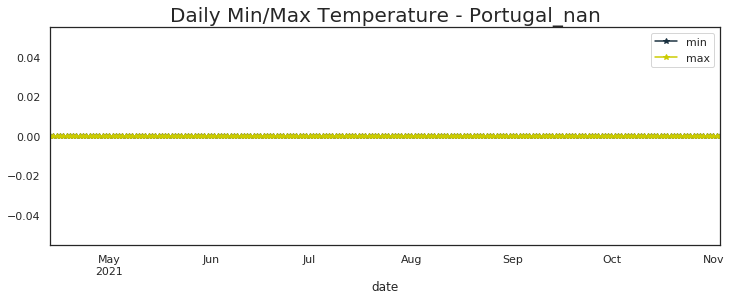

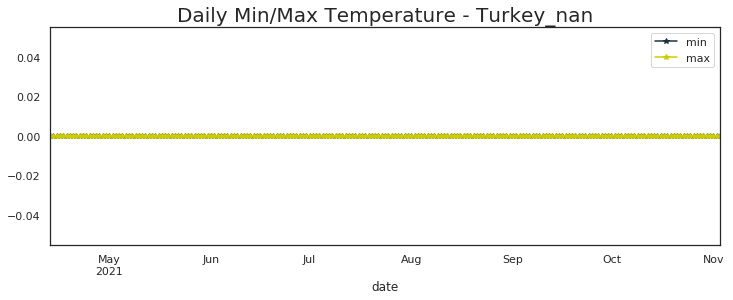

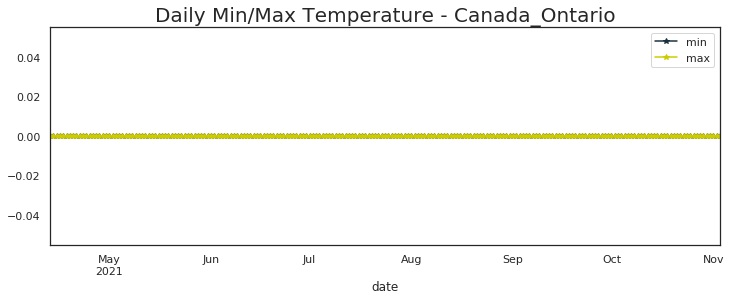

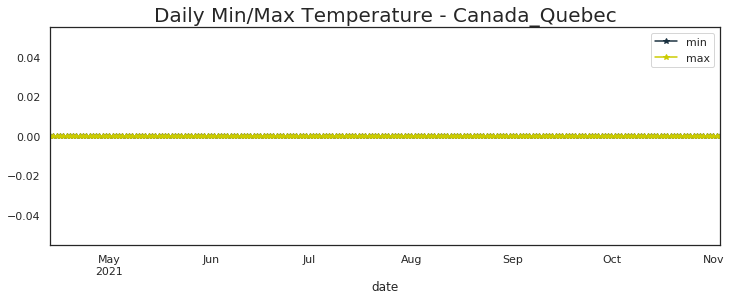

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
France_nan                  0.0  0.0
Iran_nan                    0.0  0.0
Argentina_nan               0.0  0.0
Spain_nan                   0.0  0.0
Colombia_nan                0.0  0.0
Italy_nan                   0.0  0.0
Germany_nan                 0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
Poland_nan                  0.0  0.0
South Africa_nan            0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Peru_nan                    0.0  0.0
Netherlands_nan             0.0  0.0
Iraq_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Cz

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

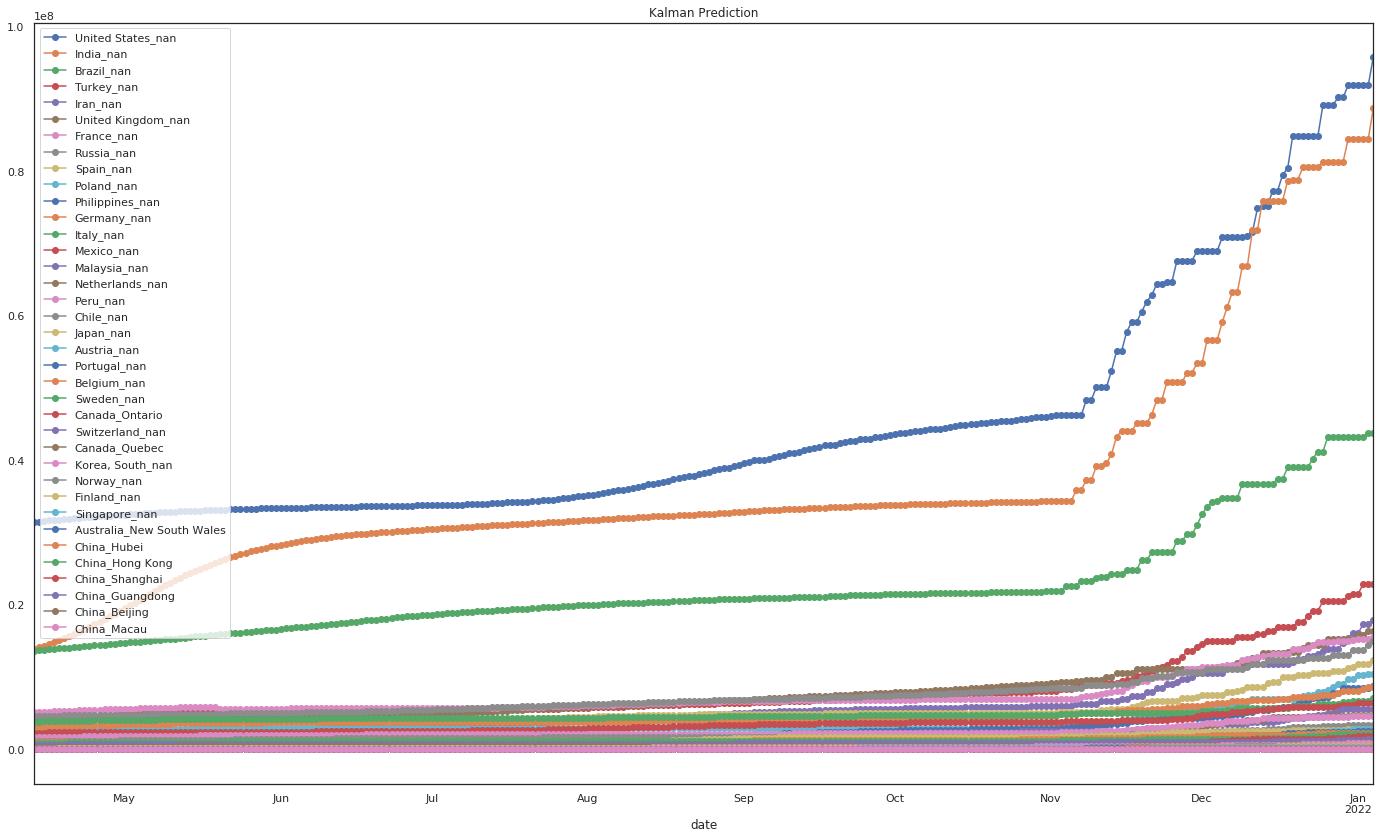

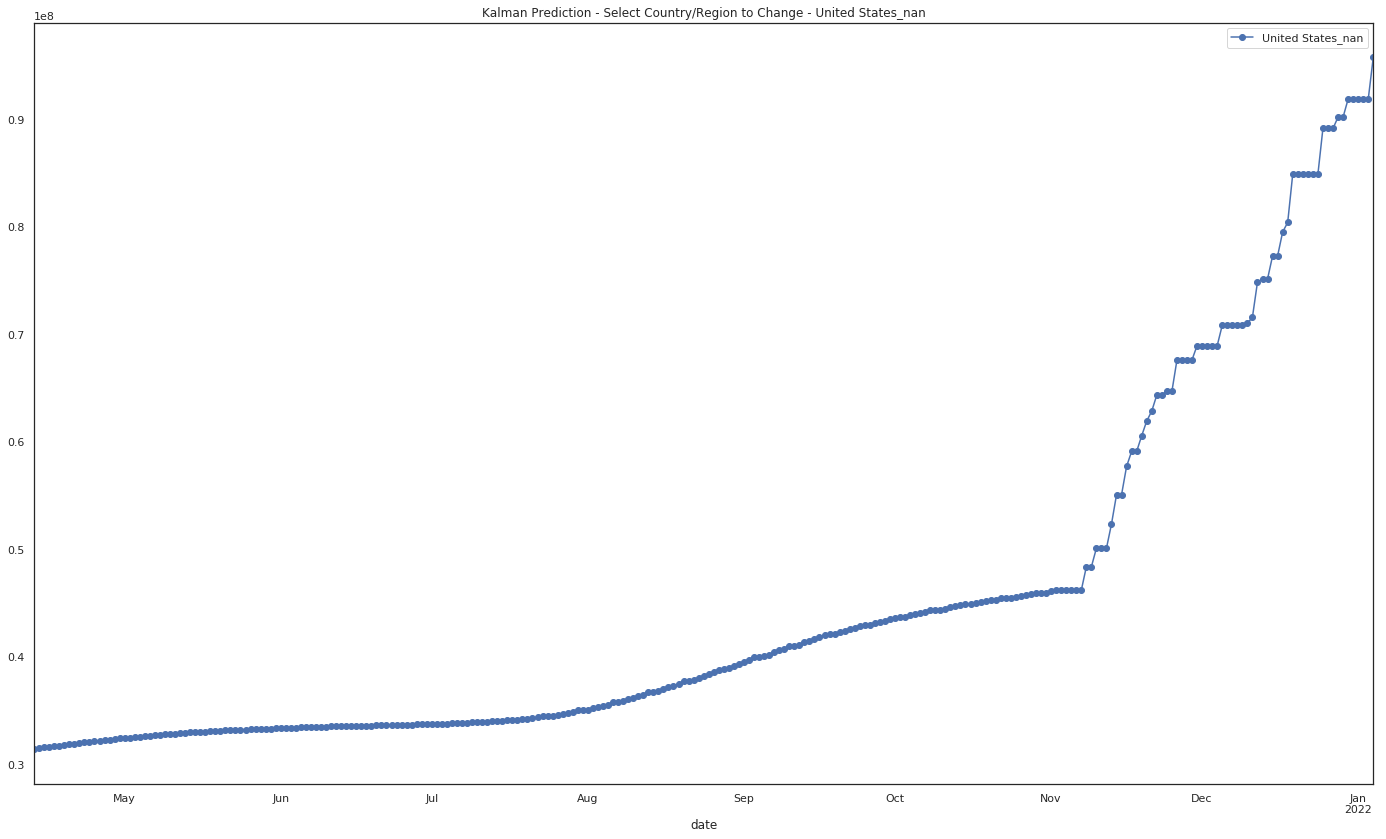

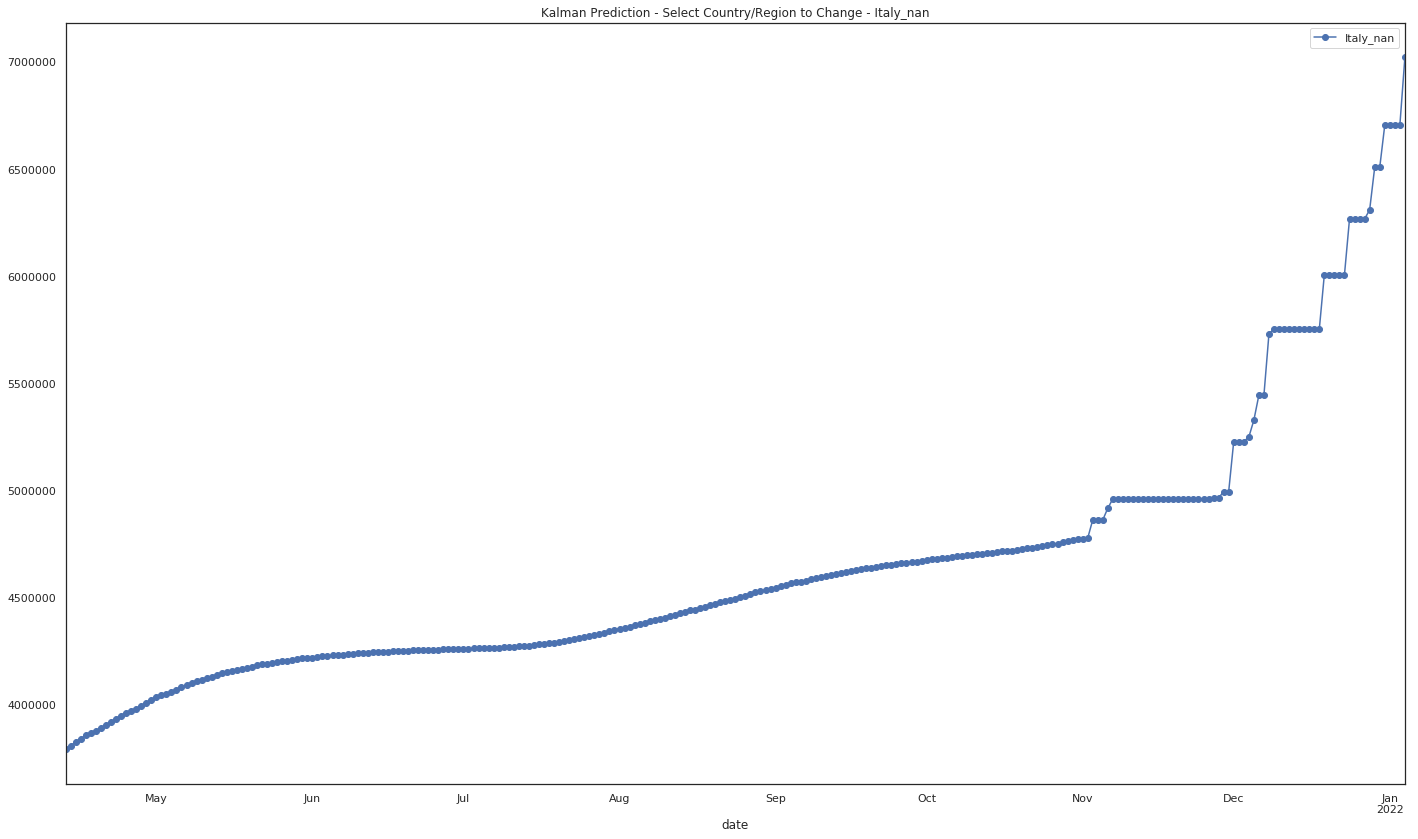

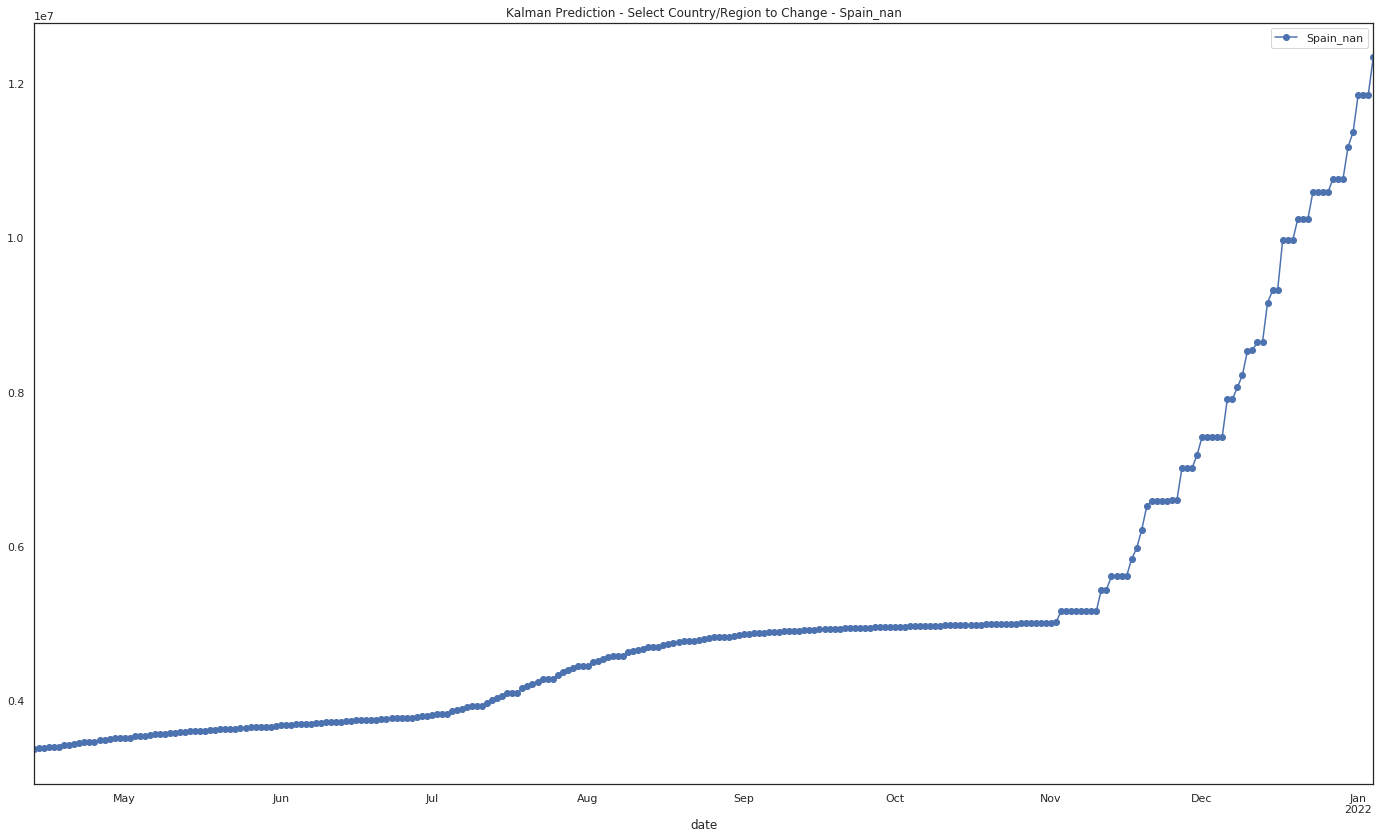

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


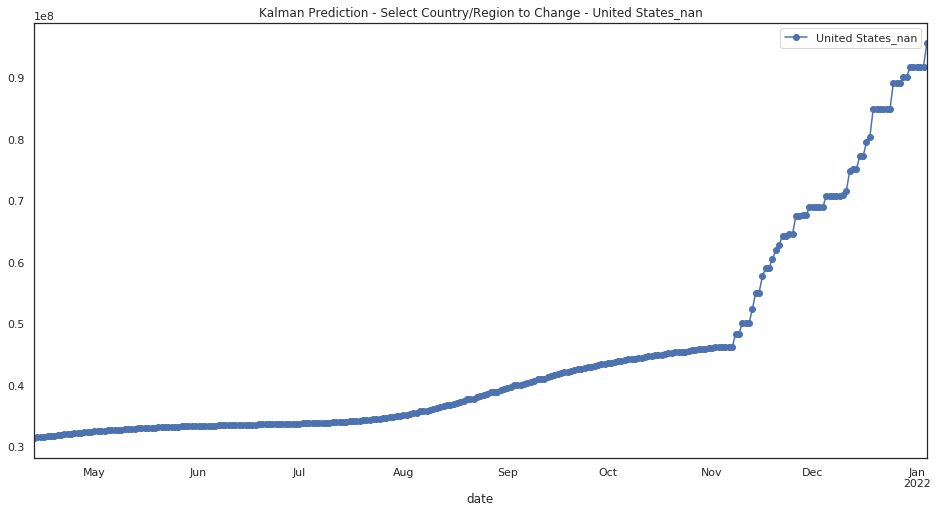

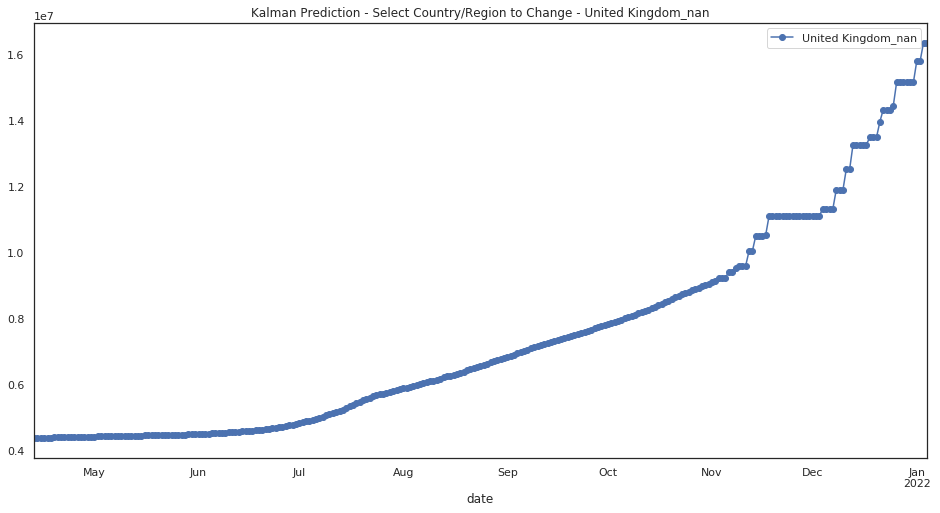

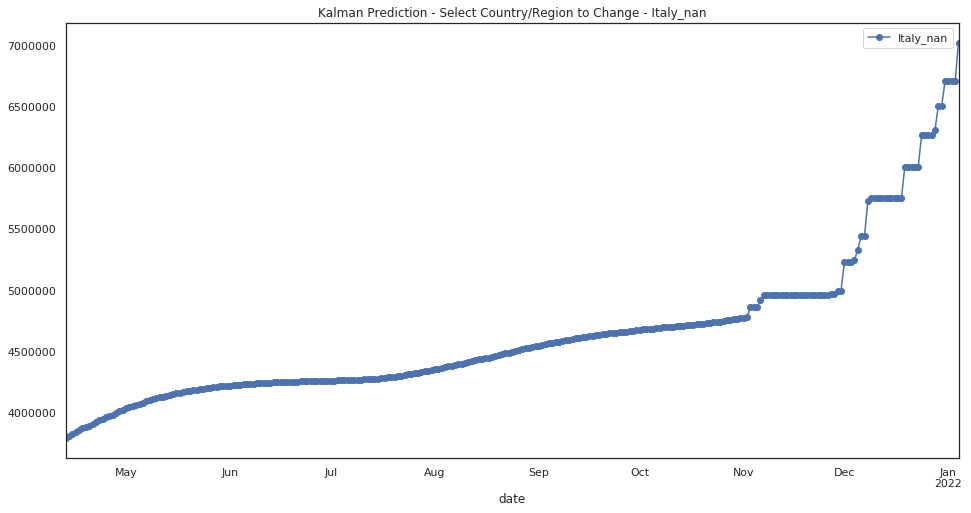

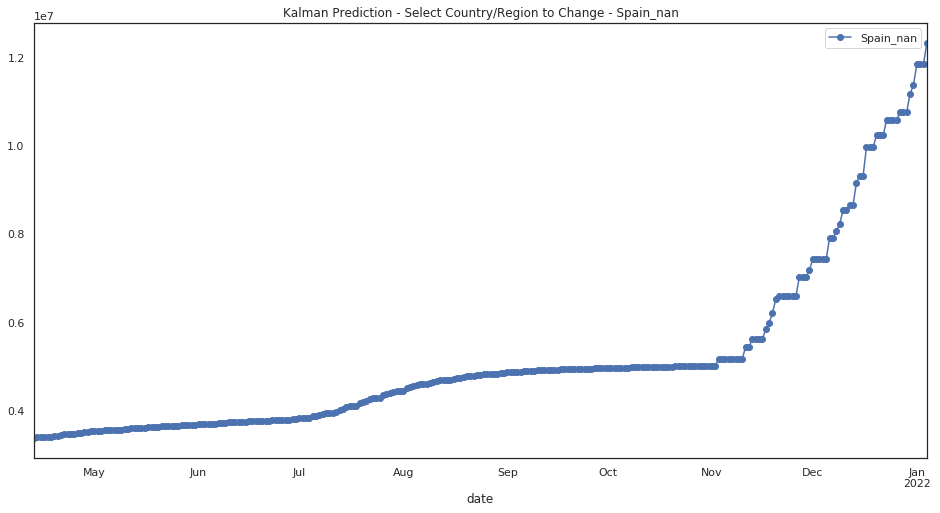

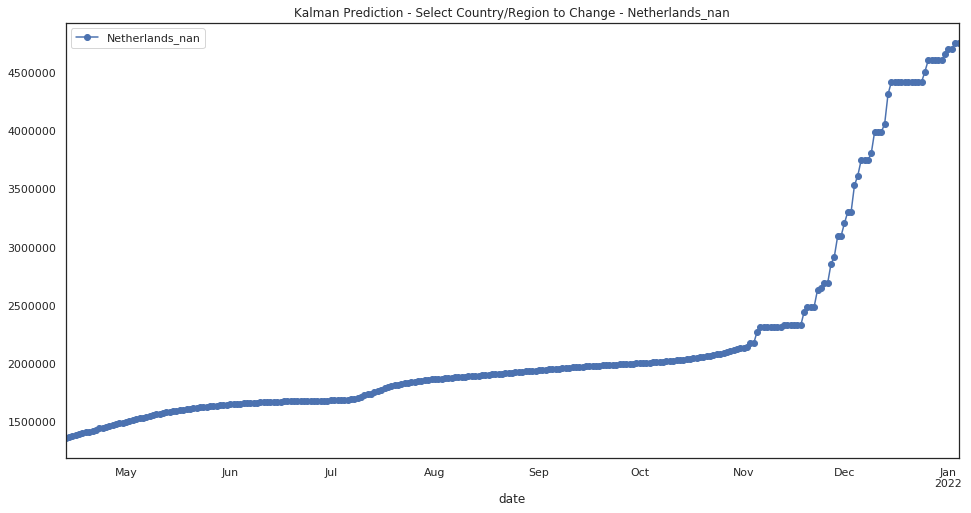

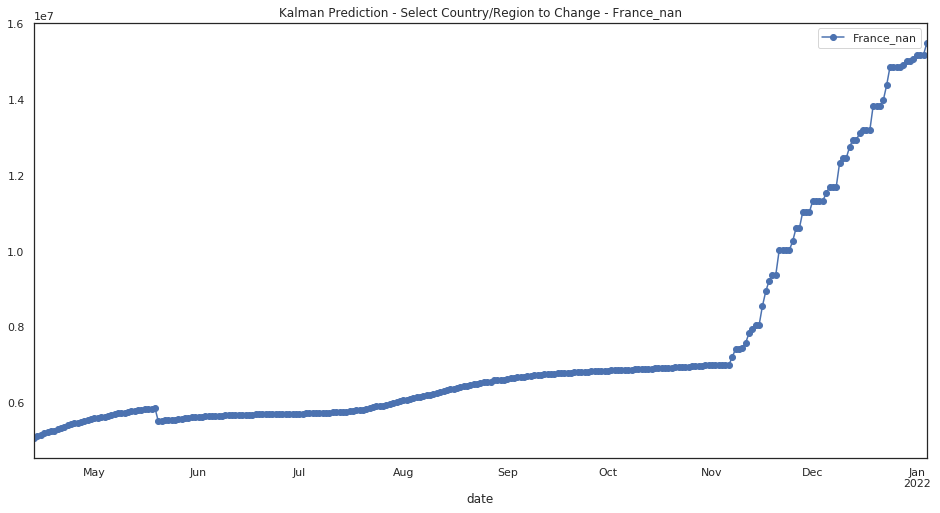

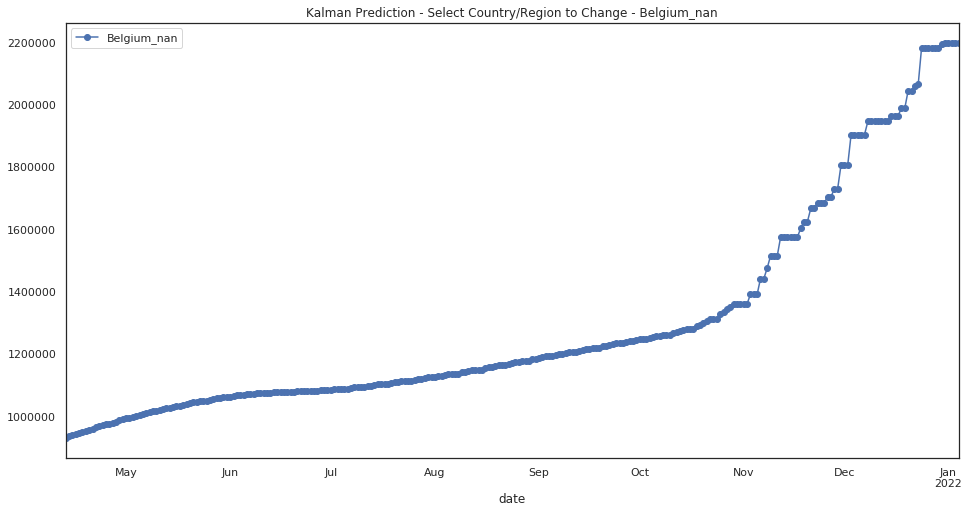

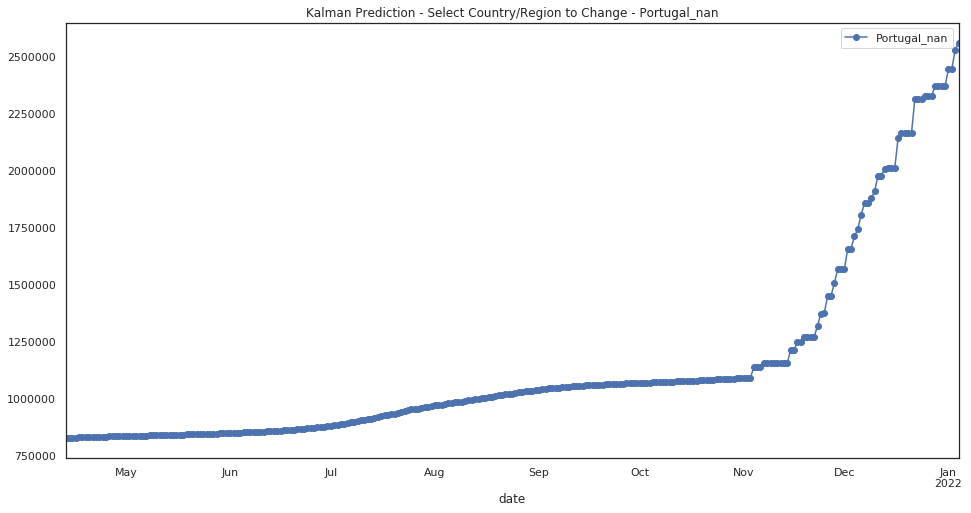

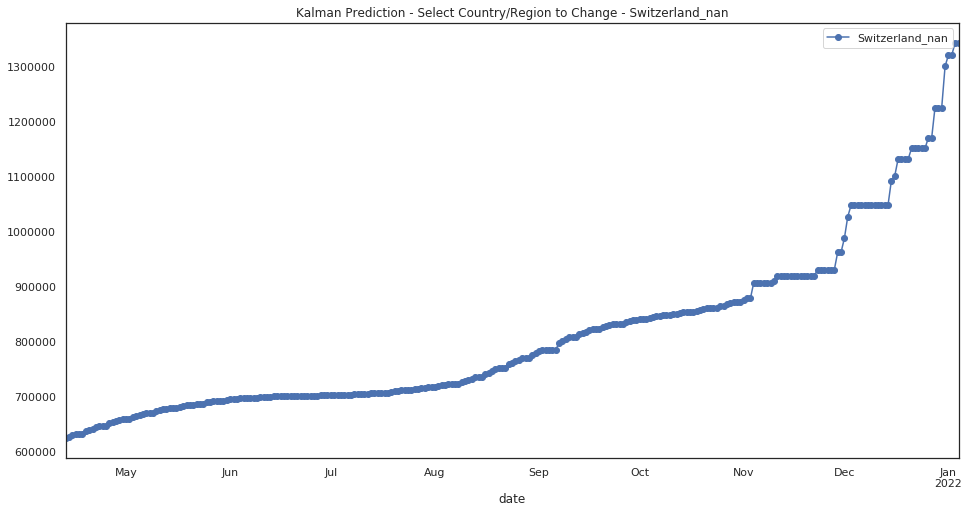

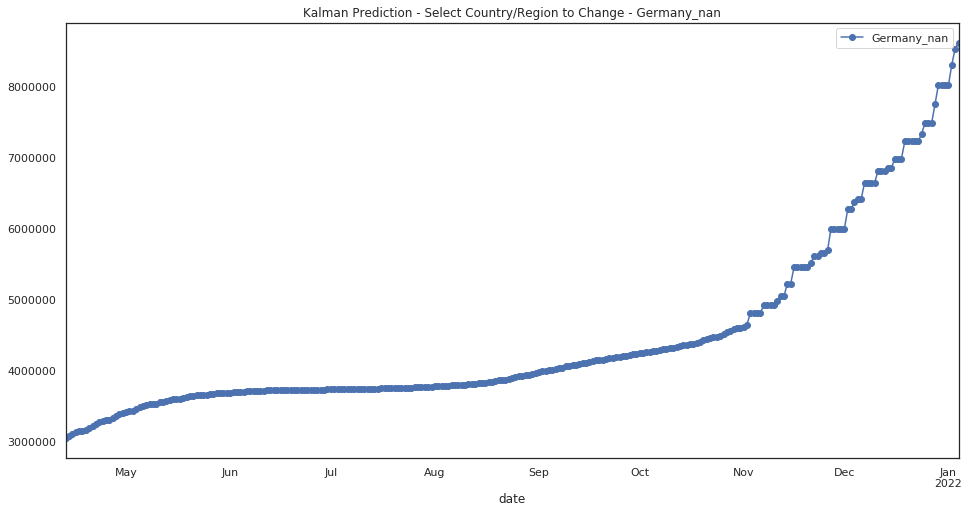

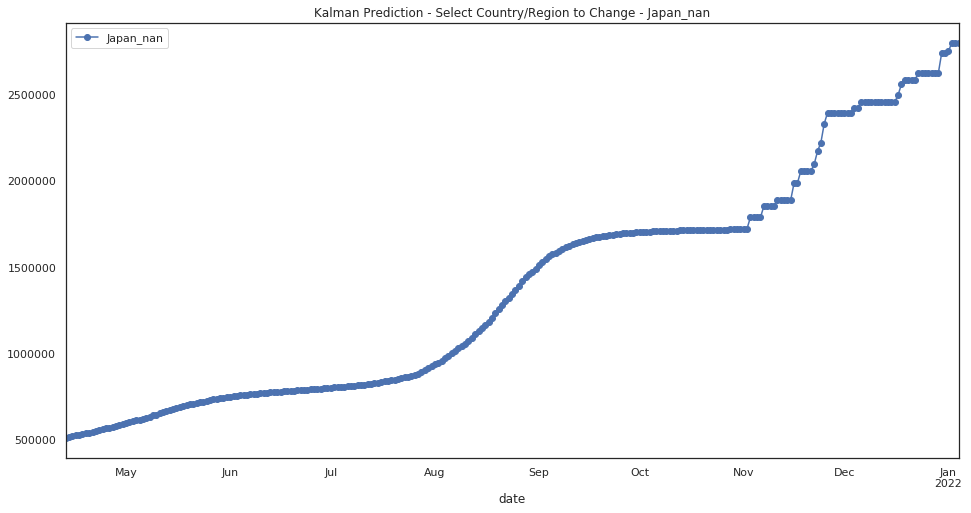

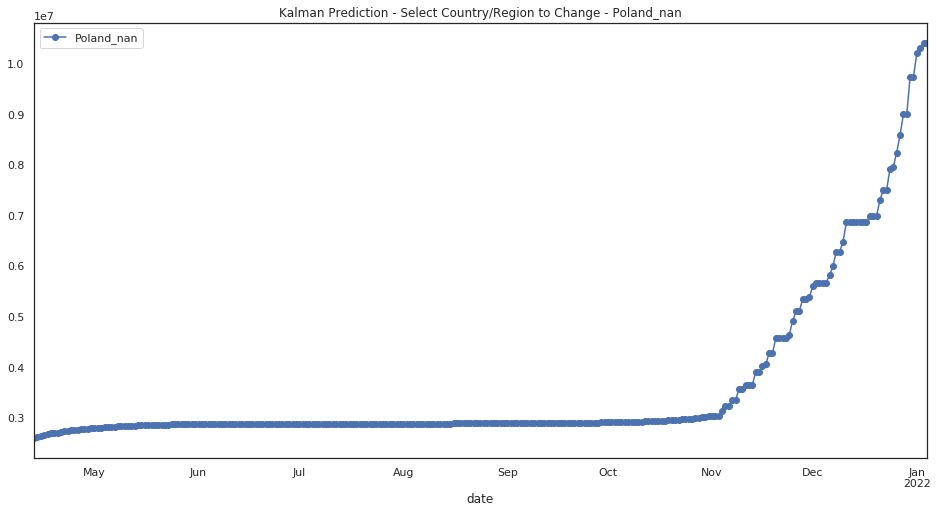

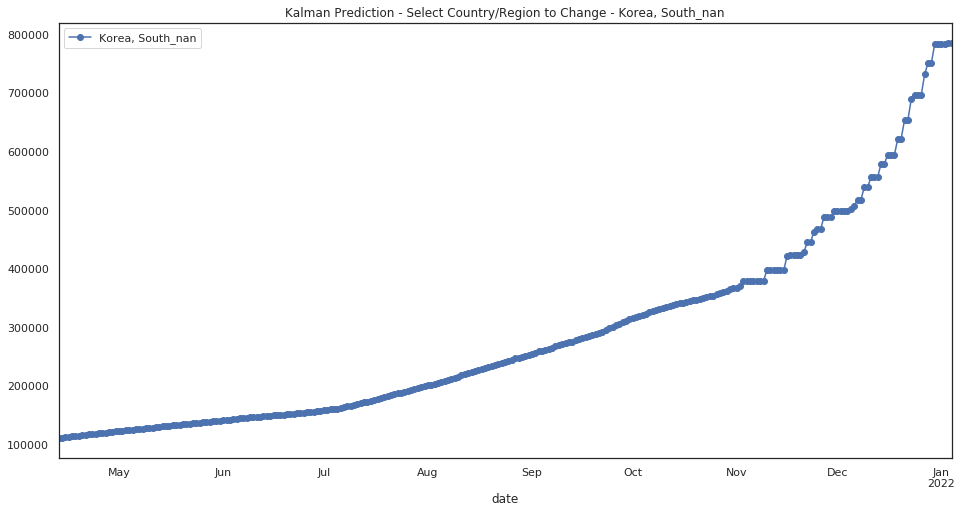

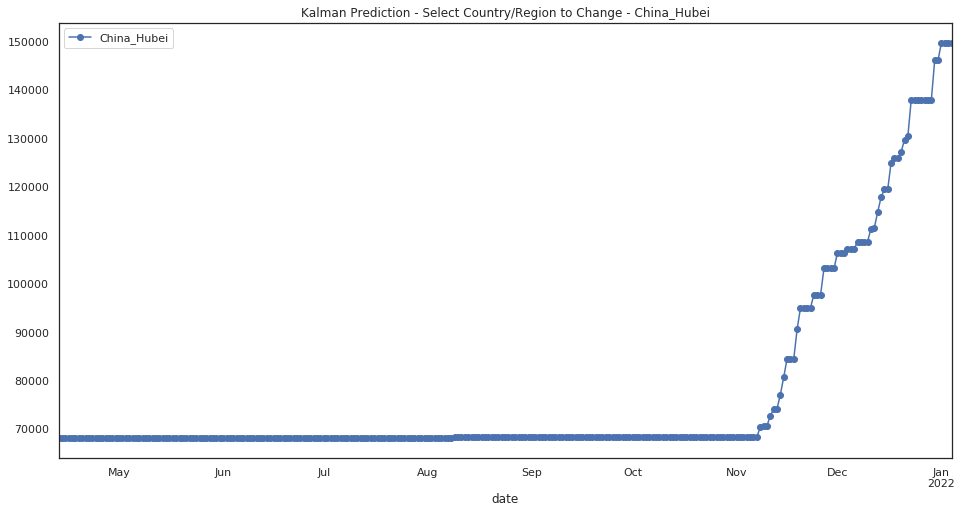

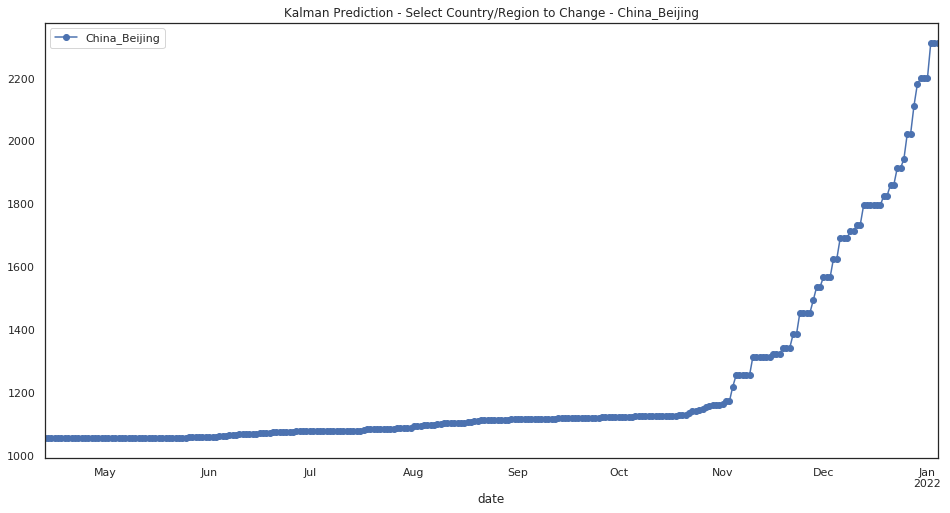

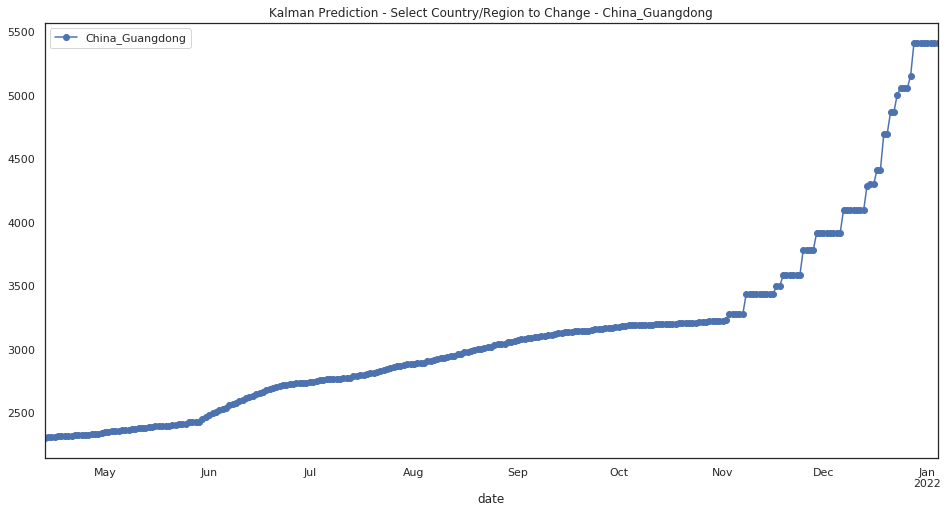

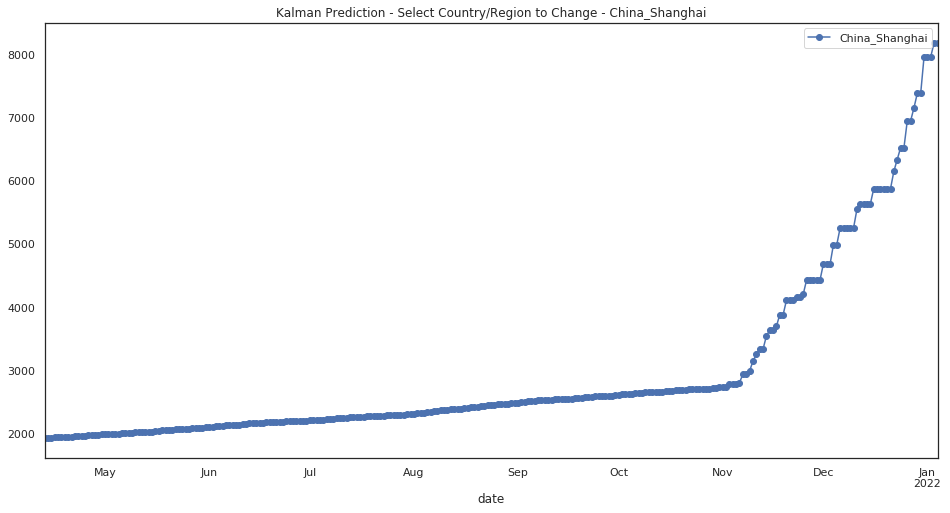

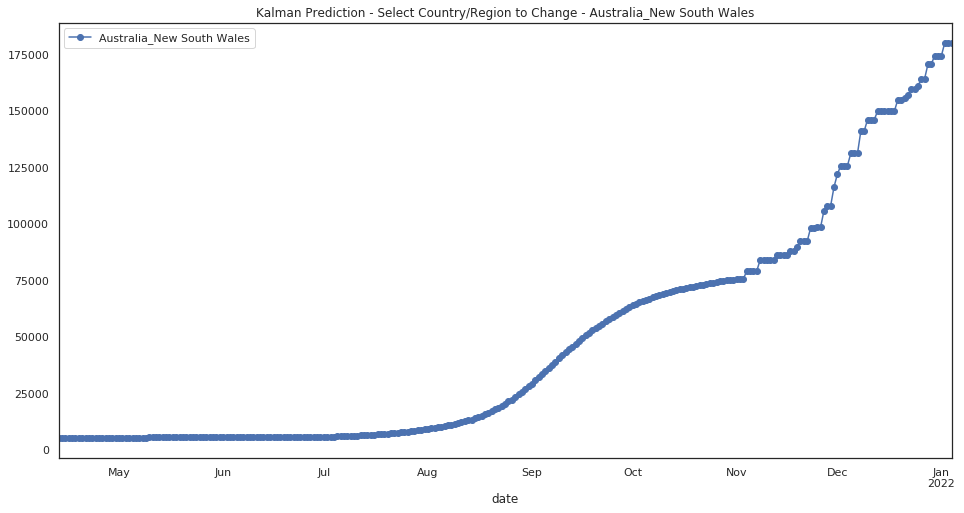

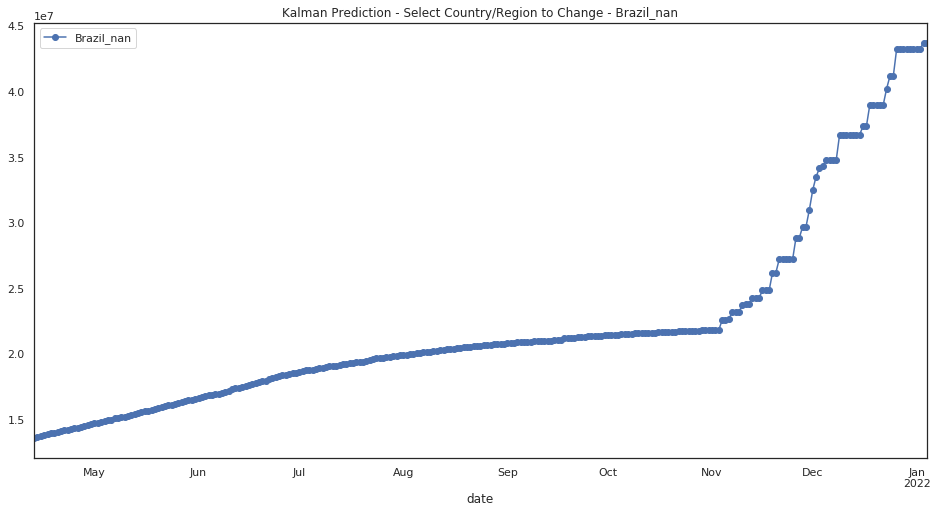

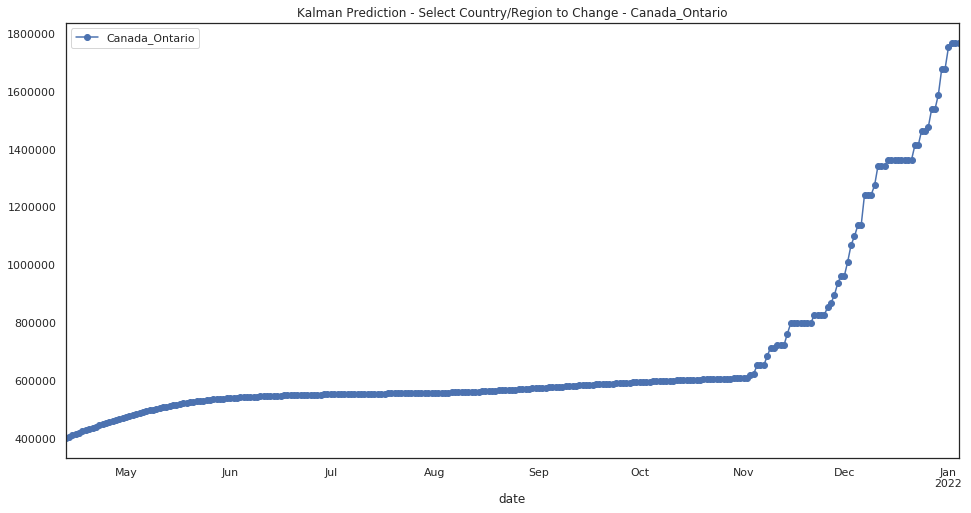

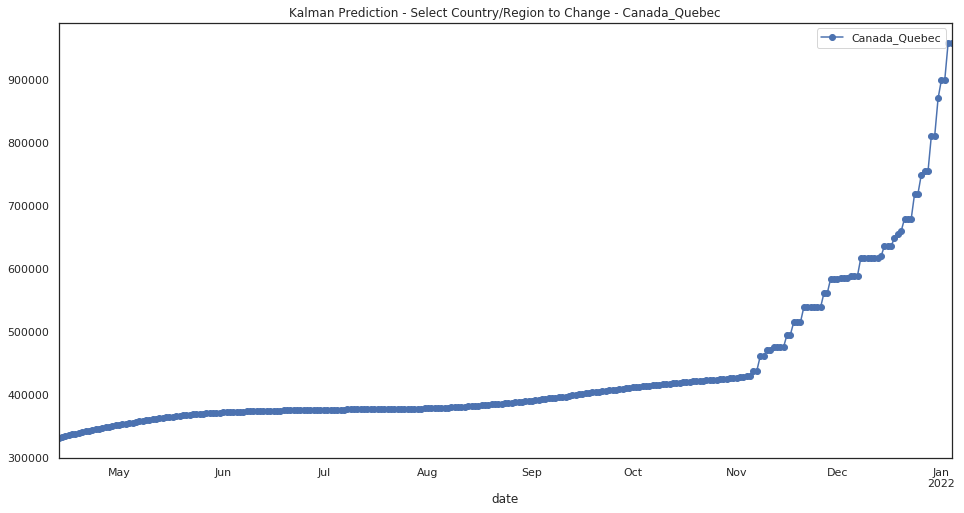

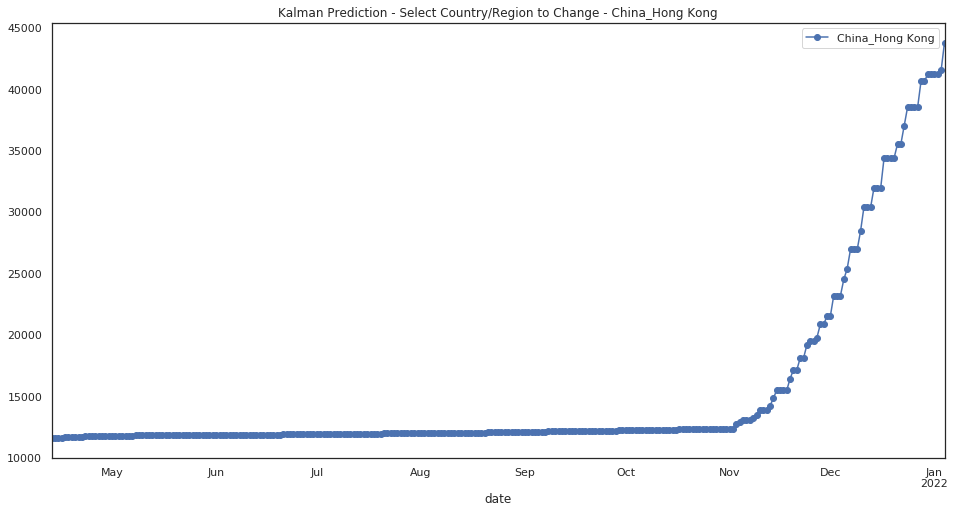

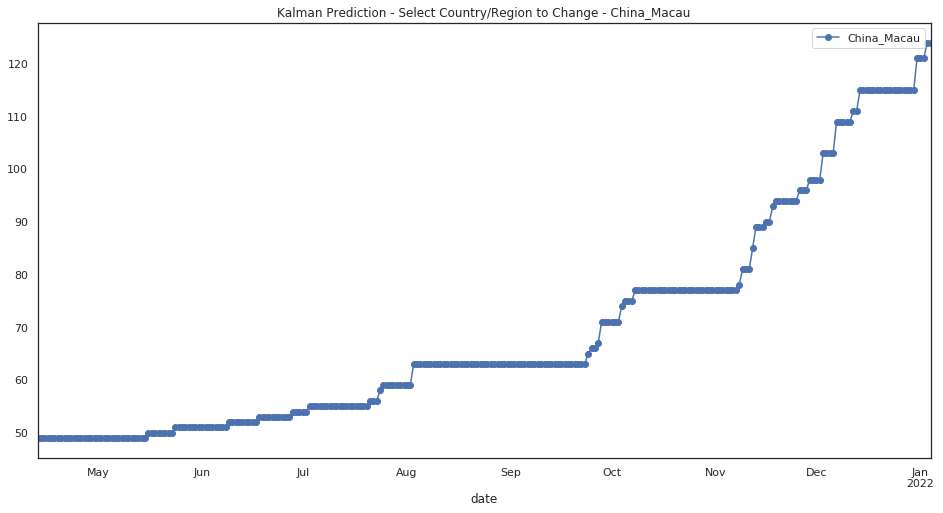

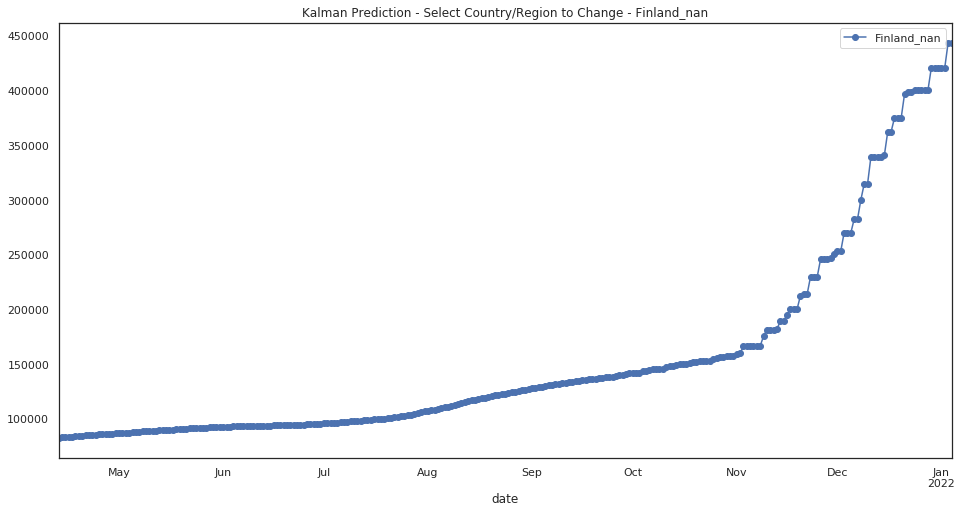

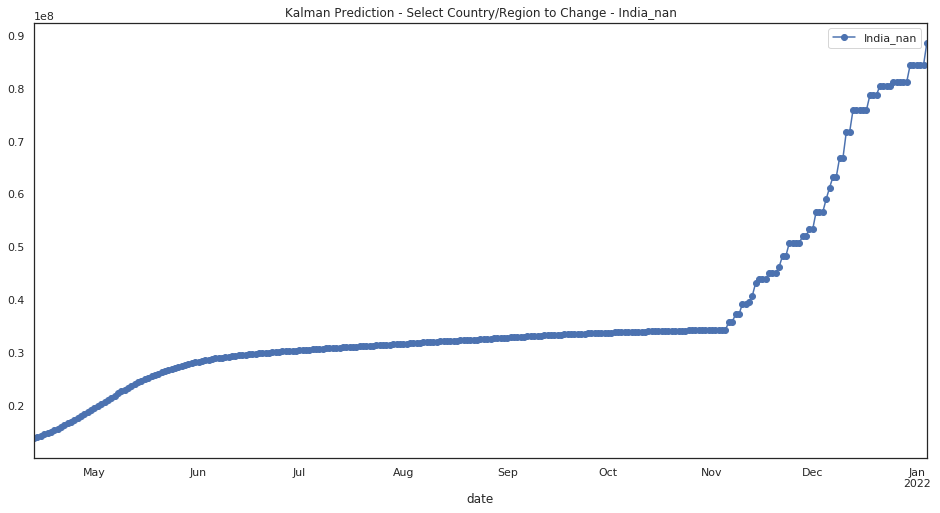

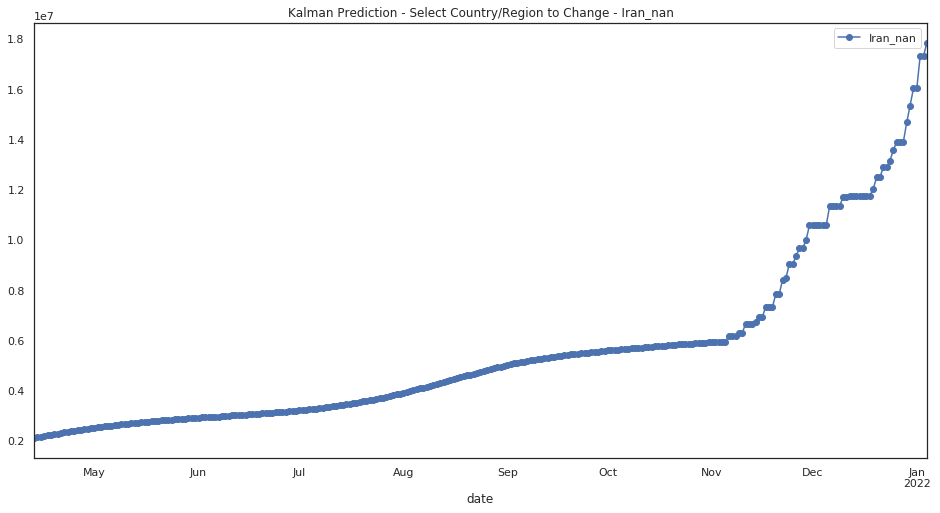

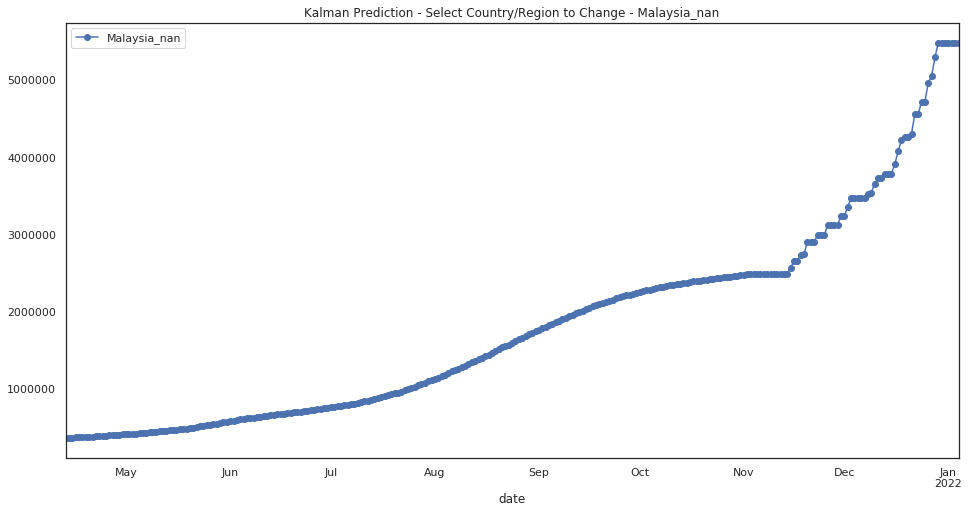

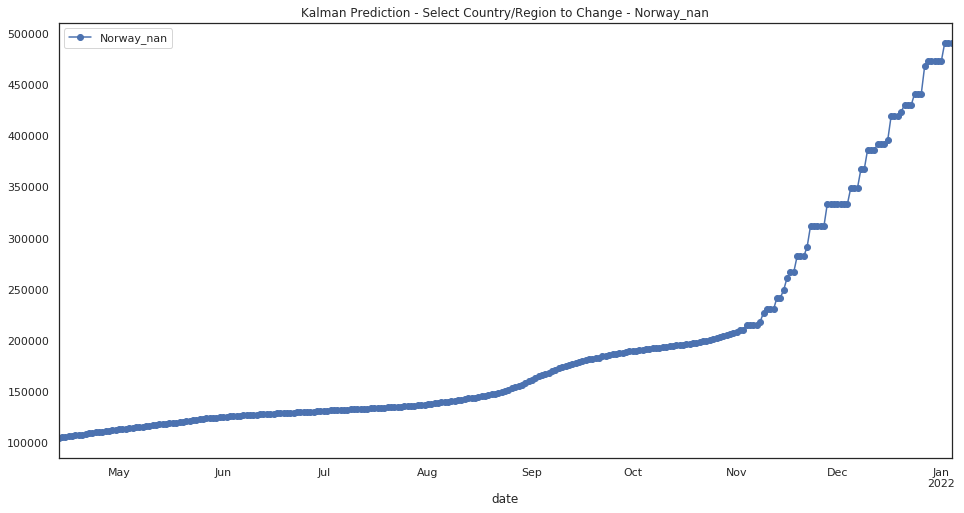

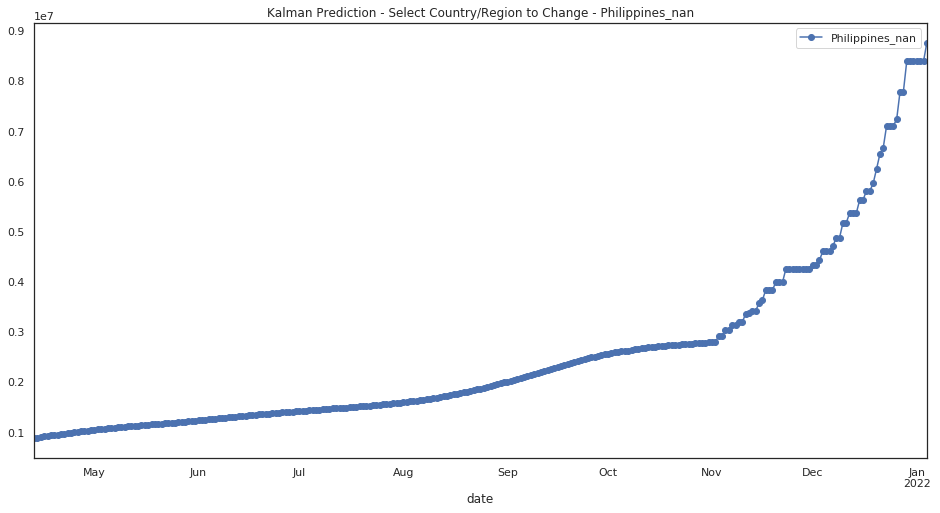

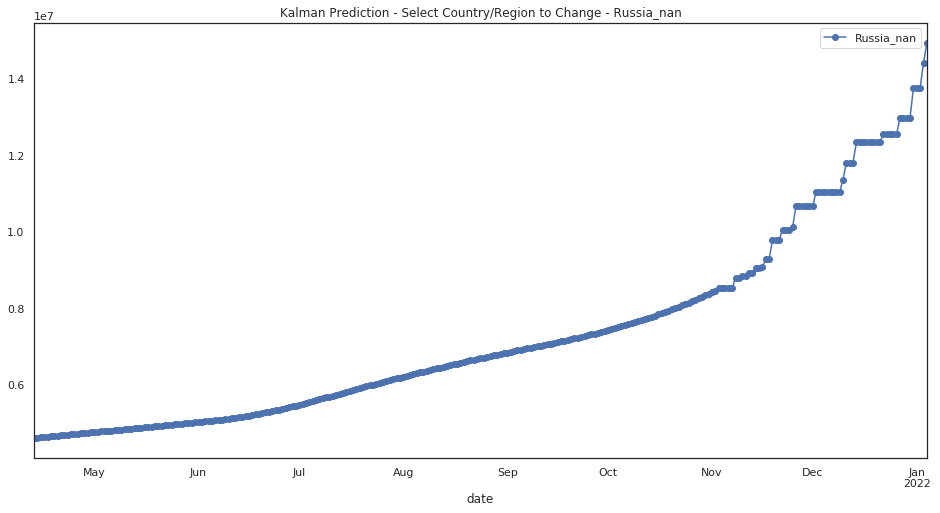

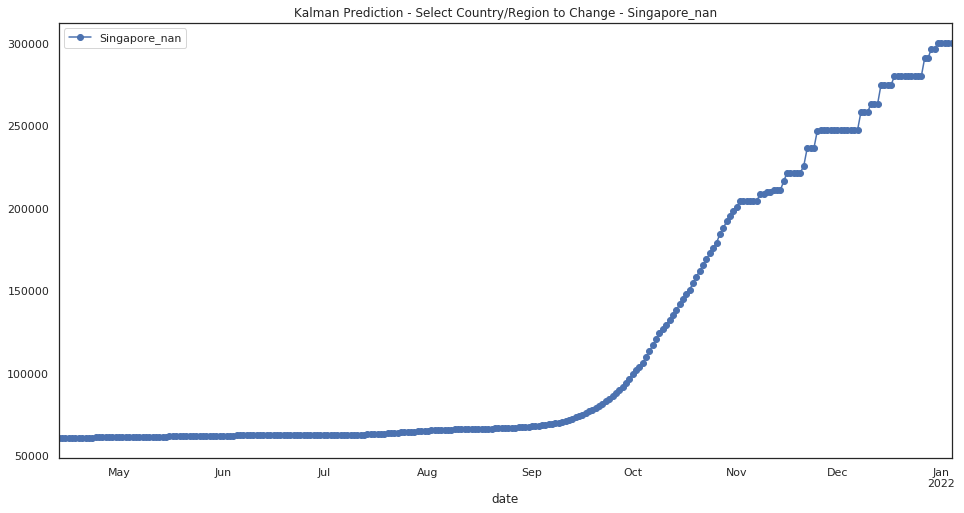

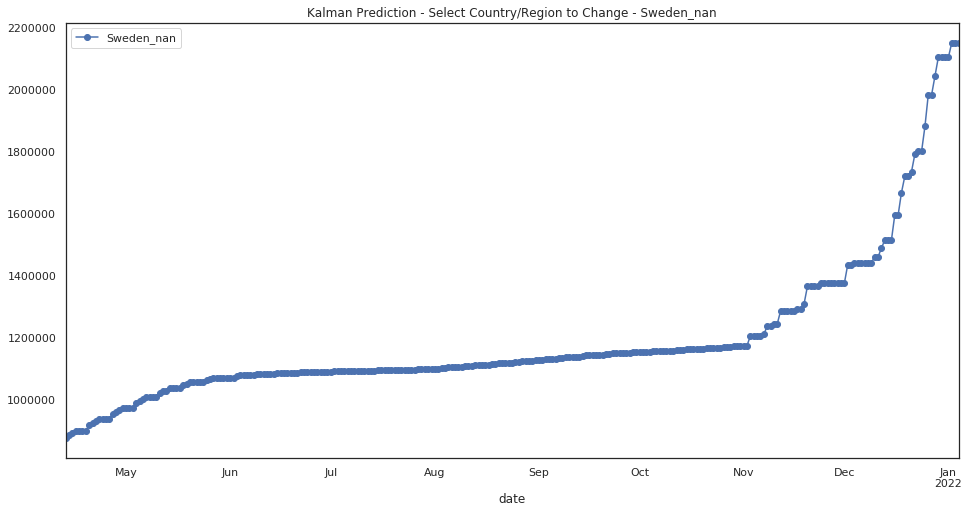

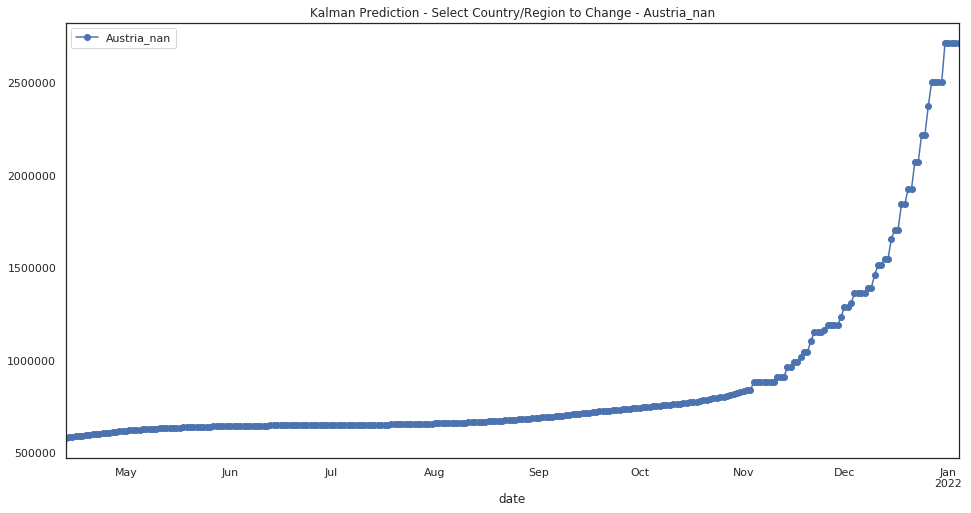

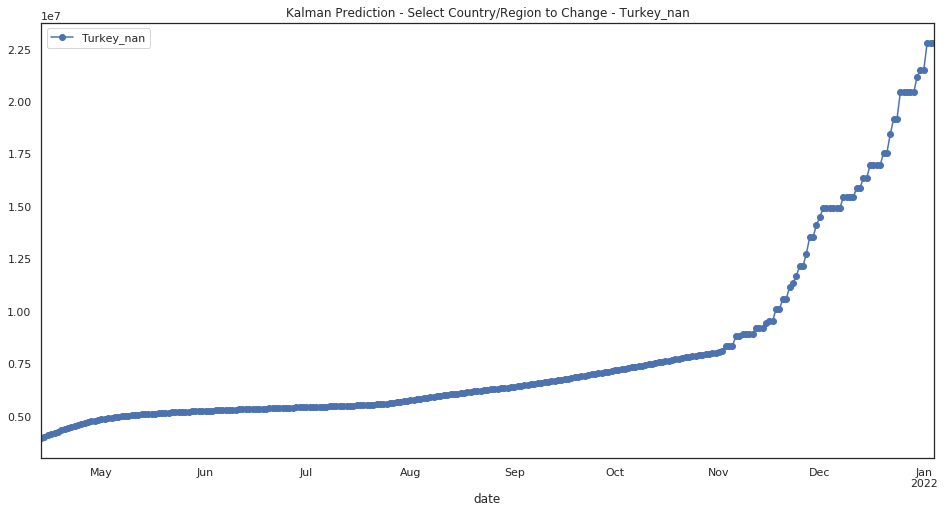

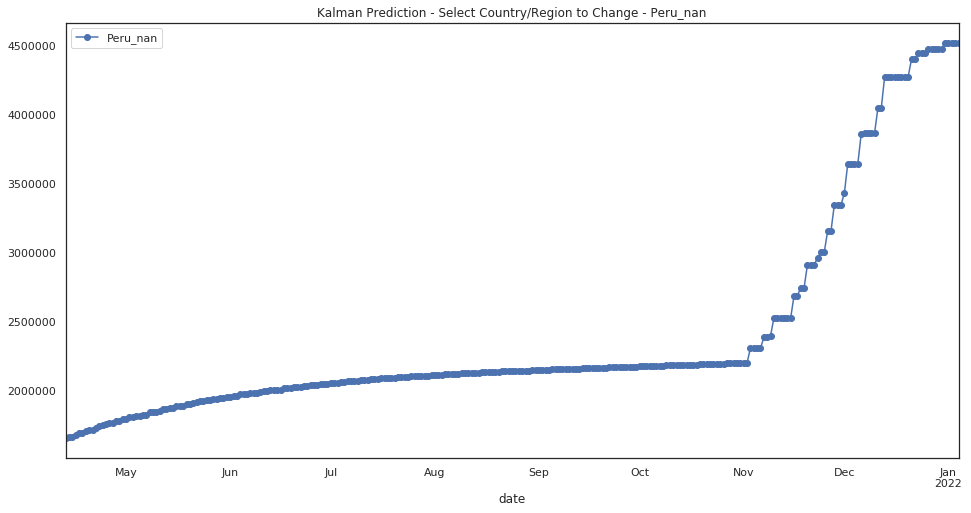

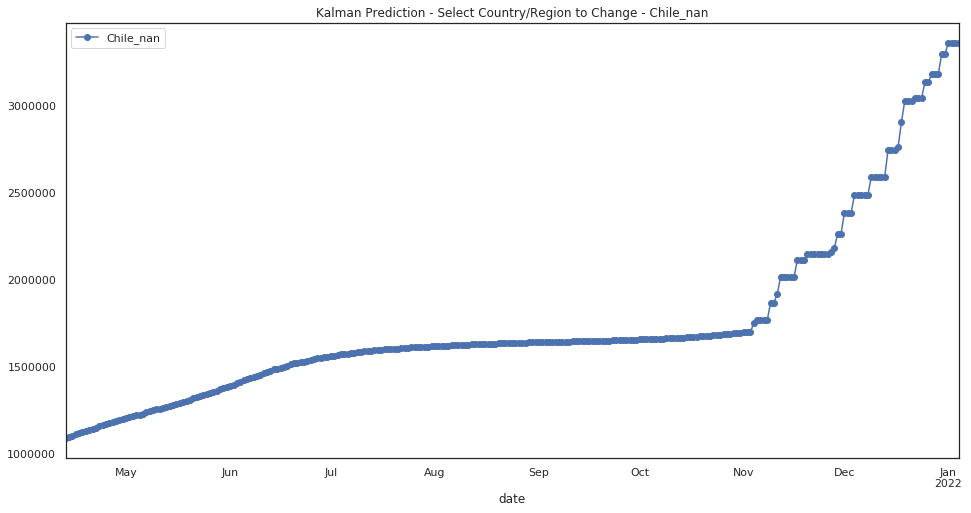

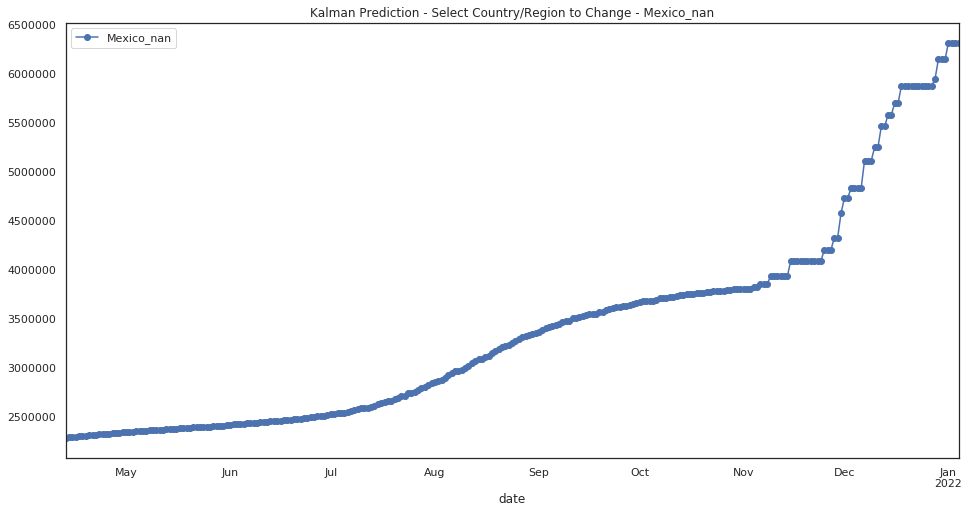

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-01-04 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      95742258.0
India_nan                                           NaN      88667810.0
Brazil_nan                                          NaN      43729181.0
Turkey_nan                                          NaN      22812525.0
Iran_nan                                            NaN      17861359.0
United Kingdom_nan                                  NaN      16378393.0
France_nan                                          NaN      15505931.0
Russia_nan                                          NaN      14953307.0
Argentina_nan                                       NaN      12457500.0
Spain_nan                                           NaN      12333437.0
Poland_nan                                          NaN      10423186.0
Colombia_nan                                        NaN      10244959.0
Philippines_nan                                     NaN       8765487.0
Germany_nan                                         NaN       8619104.0
Indonesia_nan                                       NaN       7559932.0
Italy_nan                                           NaN       7021287.0
South Africa_nan                                    NaN       7010973.0
Mexico_nan                                          NaN       6315094.0
Ukraine_nan                                         NaN       6054343.0
Iraq_nan                                            NaN       5794355.0
Malaysia_nan                                        NaN       5484535.0
Netherlands_nan                                     NaN       4756238.0
Peru_nan                                            NaN       4518597.0
Romania_nan                                         NaN       4364457.0
Czechia_nan                                         NaN       3939228.0
Pakistan_nan                                        NaN       3826591.0
Chile_nan                                           NaN       3363245.0
Thailand_nan                                        NaN       3268998.0
Bangladesh_nan                                      NaN       3015467.0
Japan_nan                                           NaN       2800851.0
...                                                 ...             ...
China_Gansu                                         NaN           726.0
China_Guangxi                                       NaN           704.0
China_Shanxi                                        NaN           618.0
Australia_Northern Territory                        NaN           445.0
China_Guizhou                                       NaN           332.0
Australia_Tasmania                                  NaN           329.0
China_Hainan                                        NaN           297.0
China_Ningxia                                       NaN           176.0
United Kingdom_Montserrat                           NaN           162.0
United Kingdom_Falkland Islands (Malvinas)          NaN           127.0
China_Macau                                         NaN           124.0
China_Qinghai                                       NaN            73.0
Holy See_nan                                        NaN            53.0
France_Saint Pierre and Miquelon                    NaN            50.0
Solomon Islands_nan                                 NaN            37.0
China_Unknown                                       NaN            37.0
Canada_Grand Princess                               NaN            36.0
Canada_Repatriated Travellers                       NaN            18.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             6.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         123017.0     184415.0     175855.0      84530.0   
2021-04-14         123128.0     184593.0     176006.0      84553.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          57853.0     129307.0     119573.0      12712.0   
2021-04-18          57890.0     129456.0     119740.0      12771.0   
2021-04-19          58039.0     129594.0     119905.0      12805.0   
2021-04-20          58133.0     129694.0     120084.0      12805.0   
2021-04-21          59266.0     130635.0     121260.0      12874.0   
2021-04-22          59335.0     130773.0     121452.0      12917.0   
2021-04-23          59647.0     130928.0     121646.0      12942.0   
2021-04-24          59687.0     131057.0     121819.0      13007.0   
2021-04-25          59866.0     131195.0     122017.0      13024.0   
2021-04-26          60124.0     131277.0     122201.0      13060.0   
2021-04-27          60255.0     131425.0     122425.0      13083.0   
2021-04-28          60366.0     131517.0     122639.0      13121.0   
2021-04-29          60645.0     131639.0     122919.0      13148.0   
2021-04-30          60750.0     131751.0     123144.0      13198.0   
2021-05-01          60982.0     131855.0     123378.0      13232.0   
2021-05-02          61139.0     131917.0     123609.0      13232.0   
2021-05-03          61333.0     131978.0     123800.0      13282.0   
2021-05-04          61591.0     132032.0     124078.0      13295.0   
2021-05-05          61733.0     132109.0     124307.0      13316.0   
2021-05-06          62121.0     132180.0     124526.0      13340.0   
2021-05-07          62284.0     132251.0     124780.0      13363.0   
2021-05-08          62675.0     132348.0     124978.0      13390.0   
2021-05-09          62791.0     132398.0     125187.0      13406.0   
2021-05-10          63225.0     132447.0     125376.0      13423.0   
2021-05-11          63390.0     132507.0     125579.0      13429.0   
2021-05-12          63575.0     132539.0     125770.0      13447.0   
...                     ...          ...          ...          ...   
2021-12-07         208932.0     252794.0     417689.0      22247.0   
2021-12-08         208645.0     256071.0     437458.0      22254.0   
2021-12-09         209963.0     257002.0     460183.0      22482.0   
2021-12-10         209963.0     256674.0     463822.0      22482.0   
2021-12-11         209860.0     256579.0     466138.0      22482.0   
2021-12-12         215641.0     256579.0     483012.0      23140.0   
2021-12-13         215367.0     259982.0     505703.0      23140.0   
2021-12-14         216786.0     260028.0     535943.0      23140.0   
2021-12-15         222599.0     271482.0     552798.0      23140.0   
2021-12-16         226564.0     273000.0     555887.0      23140.0   
2021-12-17         236226.0     273542.0     556268.0      23784.0   
2021-12-18         237470.0     273542.0     568304.0      23784.0   
2021-12-19         239237.0     286991.0     569633.0      23784.0   
2021-12-20         239467.0     288819.0     579367.0      25159.0   
2021-12-21         239296.0     289494.0     584439.0      25159.0   
2021-12-22         253233.0     301655.0     585078.0      26390.0   
2021-12-23         254026.0     302959.0     595270.0      26390.0   
2021-12-24         257560.0     303559.0     596454.0      27737.0   
2021-12-25         267789.0     303559.0     597034.0      27737.0   
2021-12-26         275459.0     313886.0     604152.0      28624.0   
2021-12-27         277770.0     315144.0     606047.0      28624.0   
2021-12-28         279666.0     326407.0     622292.0      29444.0   
2021-12-29         279510.0     327699.0     624306.0      30875.0   
2021-12-30         279155.0     342901.0     625127.0      32198.0   
2021-12-31

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Turkey_nan',
 'Iran_nan',
 'United Kingdom_nan',
 'France_nan',
 'Russia_nan',
 'Argentina_nan',
 'Spain_nan',
 'Poland_nan',
 'Colombia_nan',
 'Philippines_nan',
 'Germany_nan',
 'Indonesia_nan',
 'Italy_nan',
 'South Africa_nan',
 'Mexico_nan',
 'Ukraine_nan',
 'Iraq_nan',
 'Malaysia_nan',
 'Netherlands_nan',
 'Peru_nan',
 'Romania_nan',
 'Czechia_nan',
 'Pakistan_nan',
 'Chile_nan',
 'Thailand_nan',
 'Bangladesh_nan',
 'Japan_nan',
 'Austria_nan',
 'Portugal_nan',
 'Cuba_nan',
 'Vietnam_nan',
 'Israel_nan',
 'Serbia_nan',
 'Belgium_nan',
 'Sweden_nan',
 'Morocco_nan',
 'Hungary_nan',
 'Greece_nan',
 'Jordan_nan',
 'Canada_Ontario',
 'Azerbaijan_nan',
 'Kazakhstan_nan',
 'Croatia_nan',
 'Nepal_nan',
 'Lebanon_nan',
 'Sri Lanka_nan',
 'Panama_nan',
 'Switzerland_nan',
 'Bulgaria_nan',
 'Tunisia_nan',
 'Ecuador_nan',
 'Bolivia_nan',
 'Lithuania_nan',
 'Georgia_nan',
 'Burma_nan',
 'Slovakia_nan',
 'Paraguay_nan',
 'Costa Rica_nan',
 

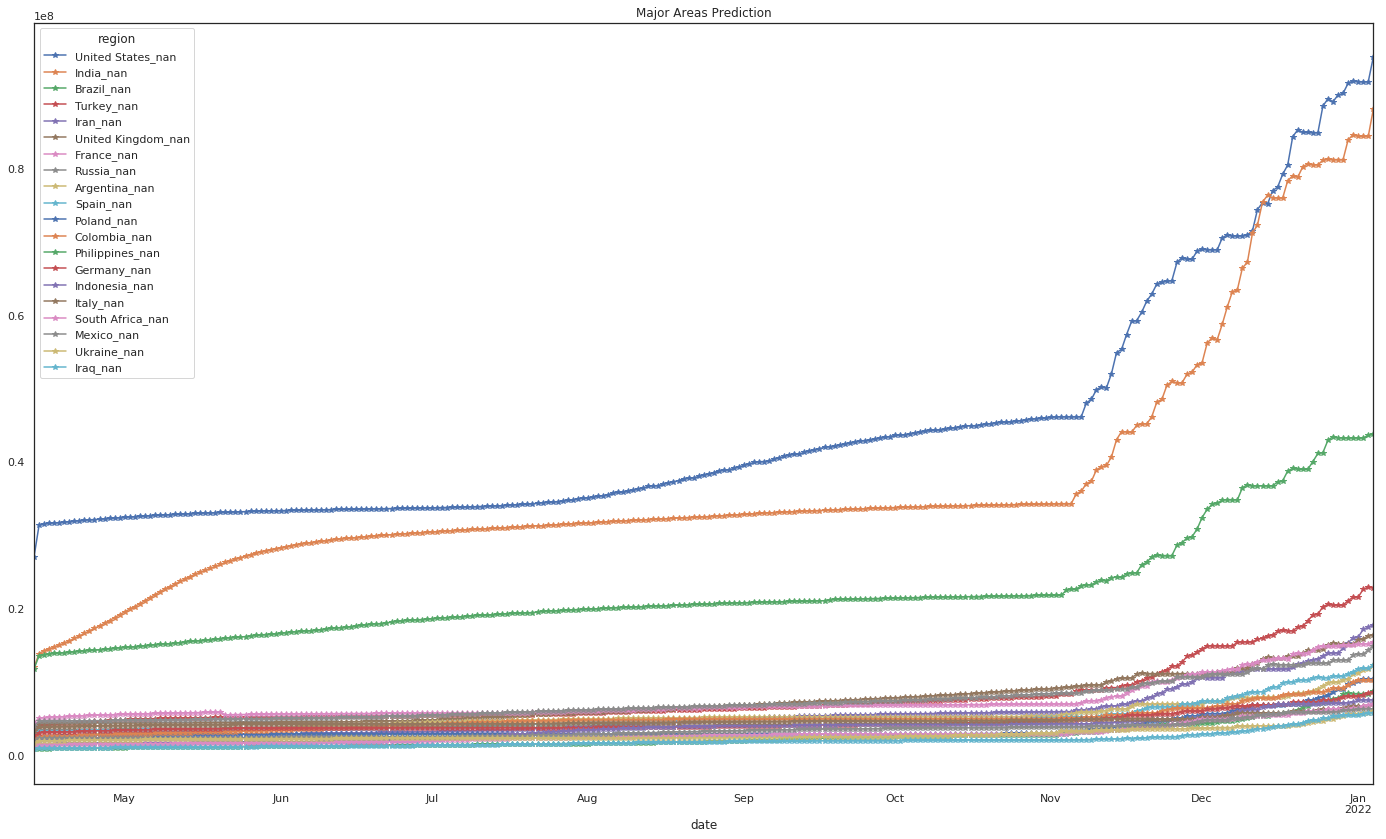

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

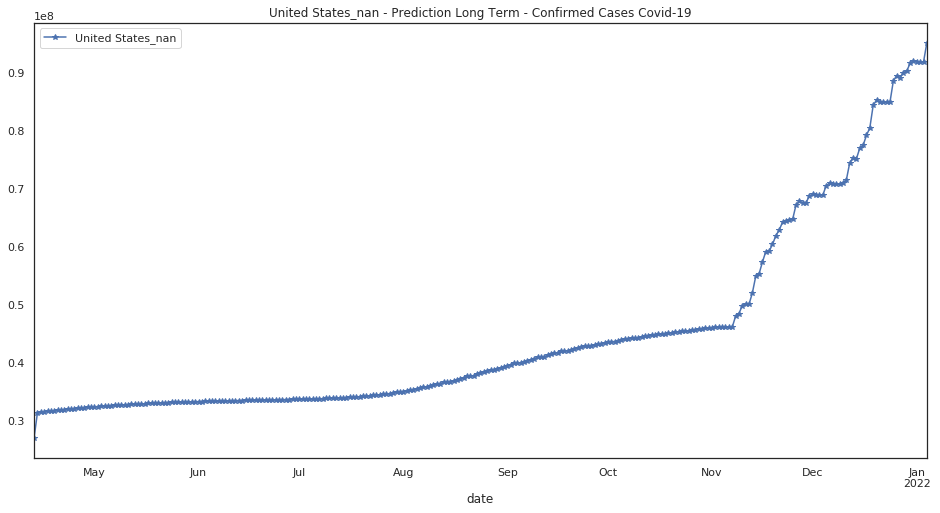

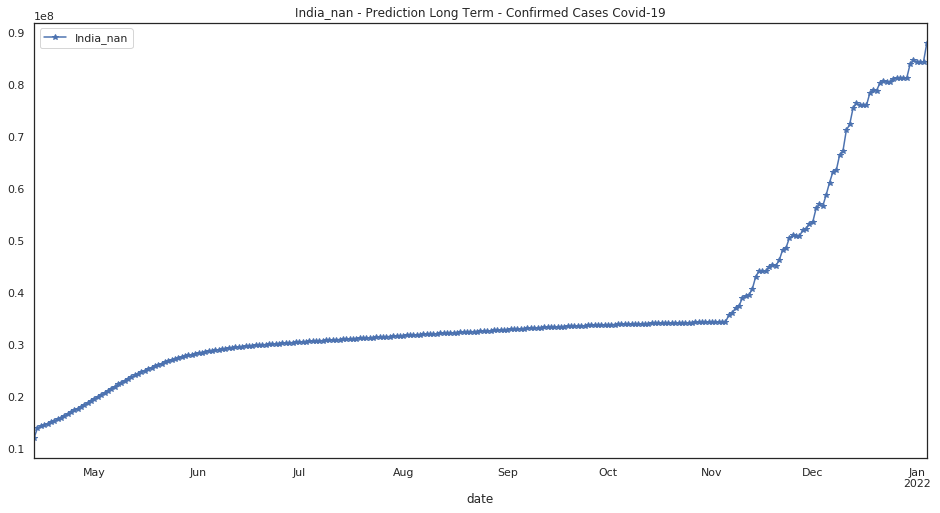

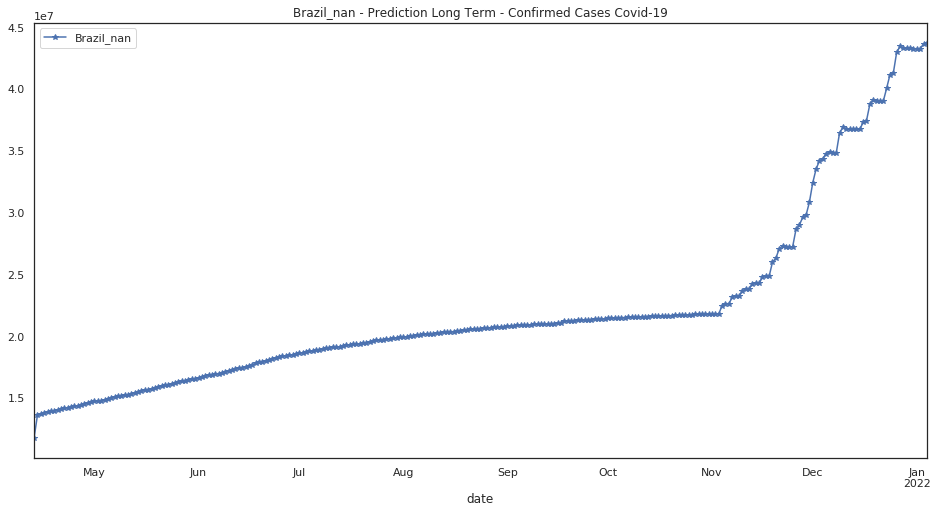

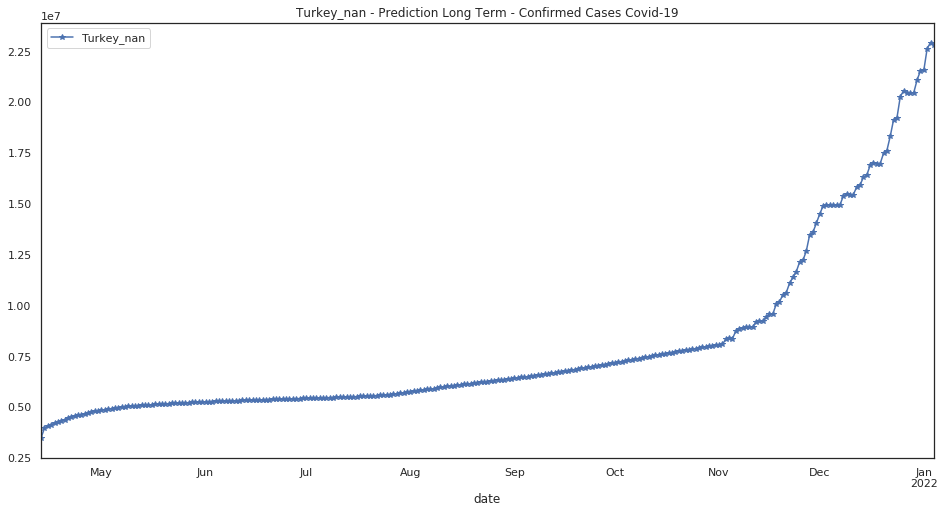

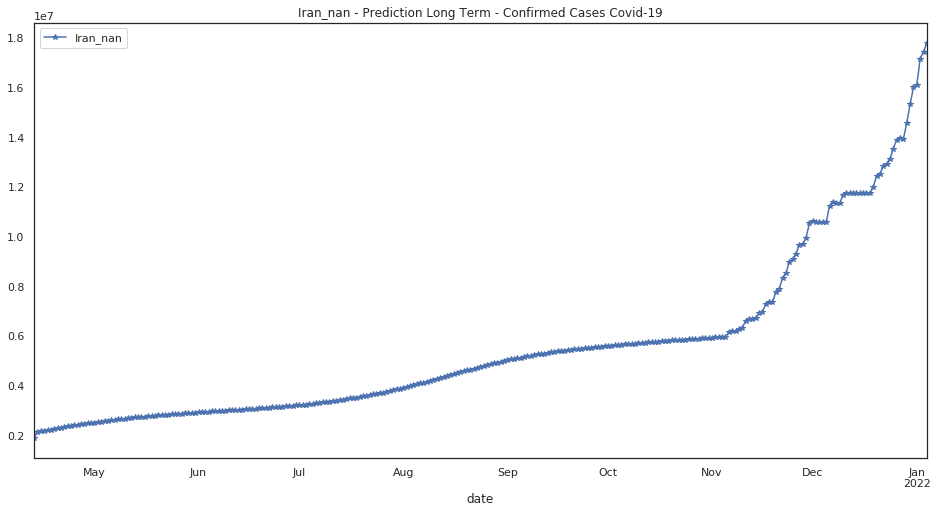

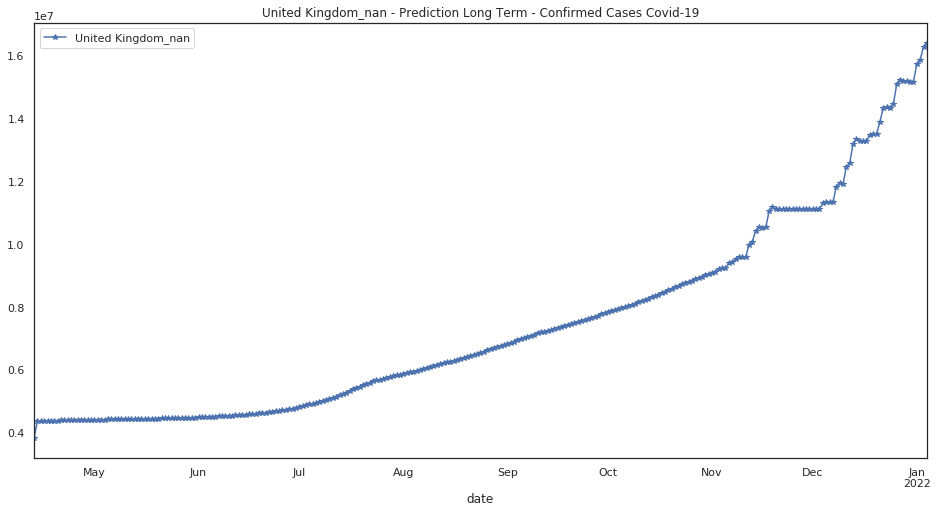

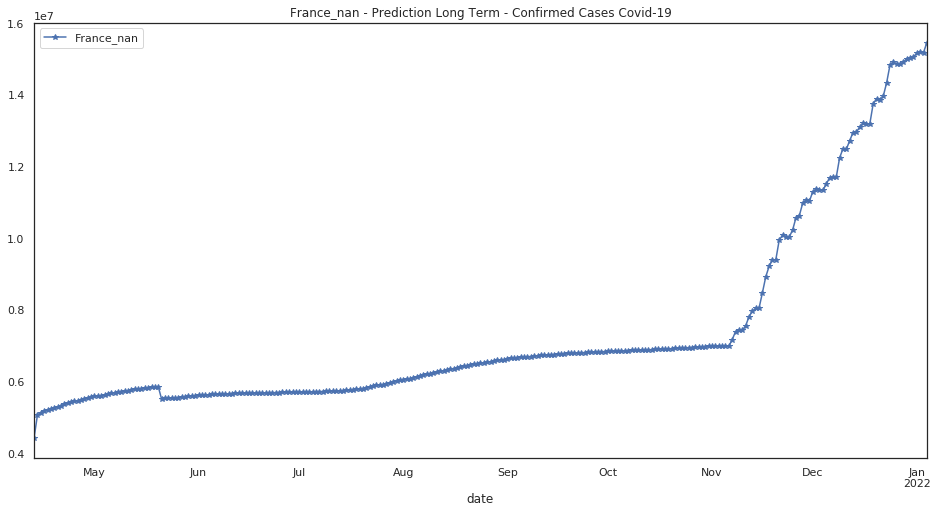

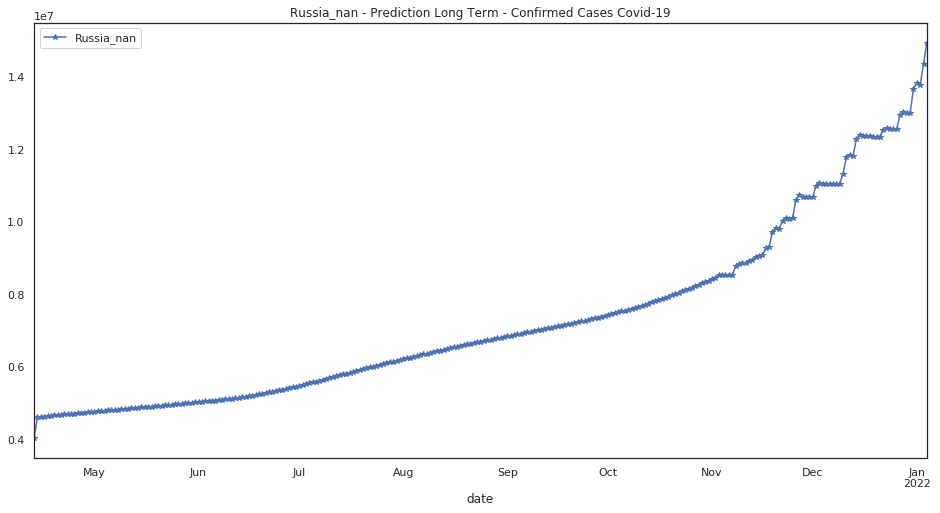

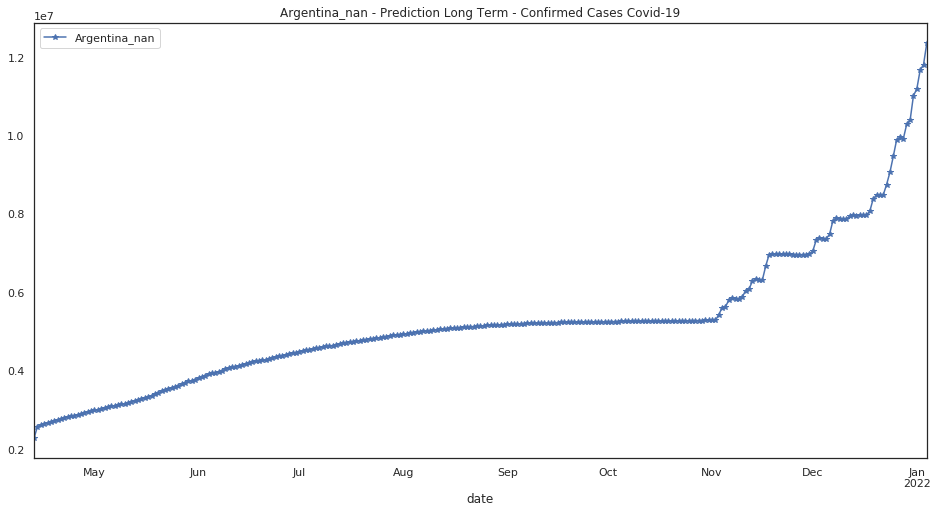

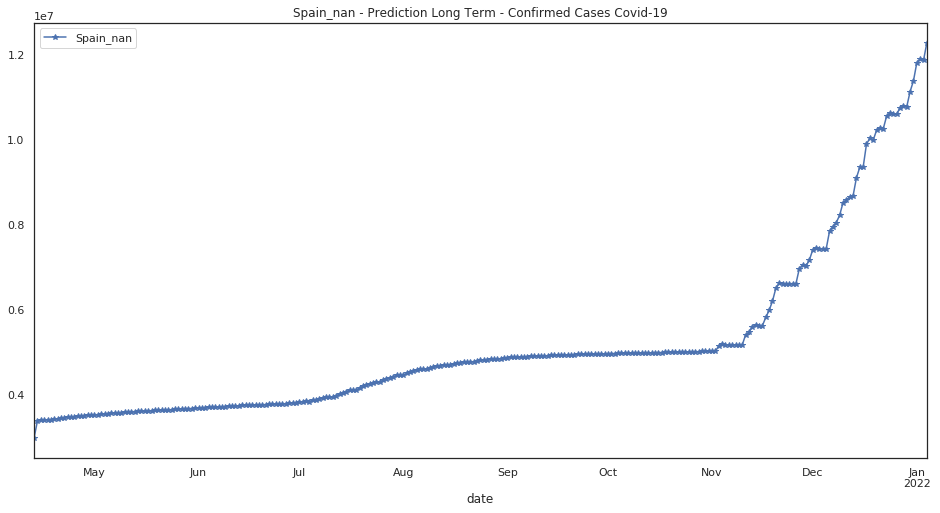

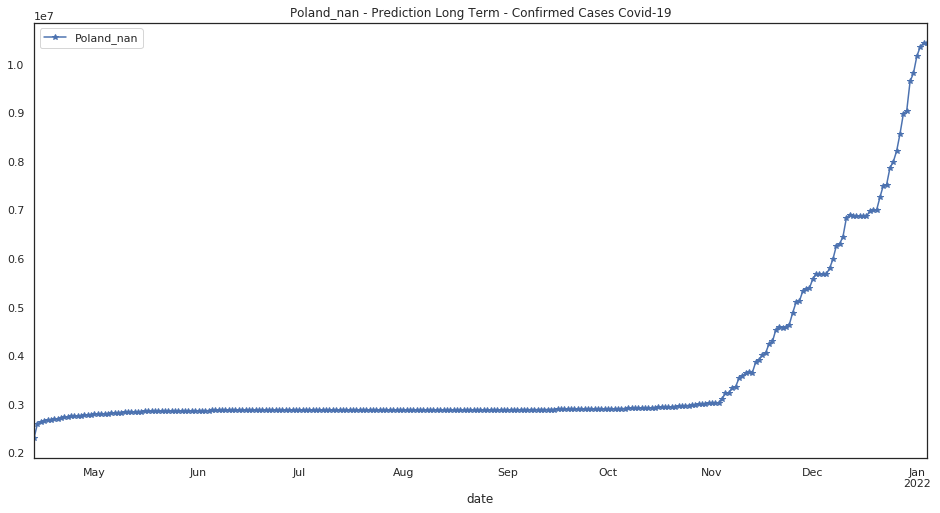

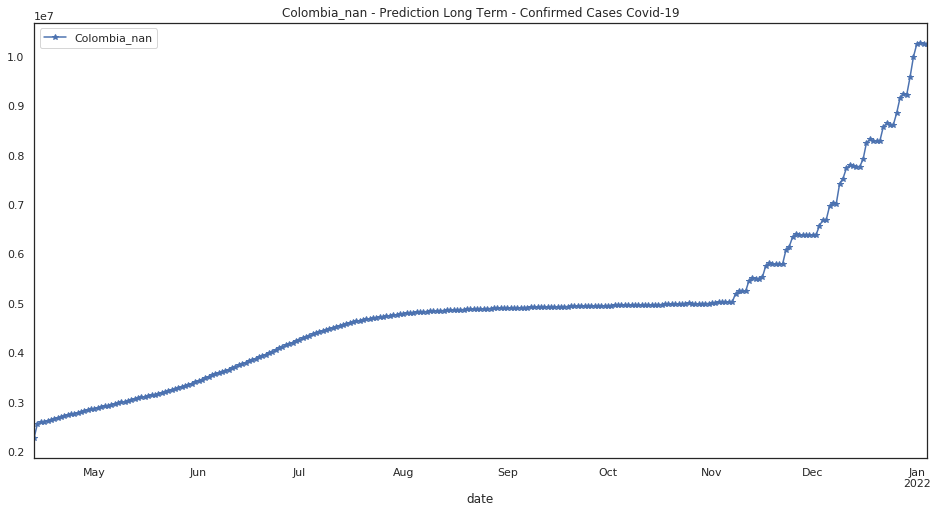

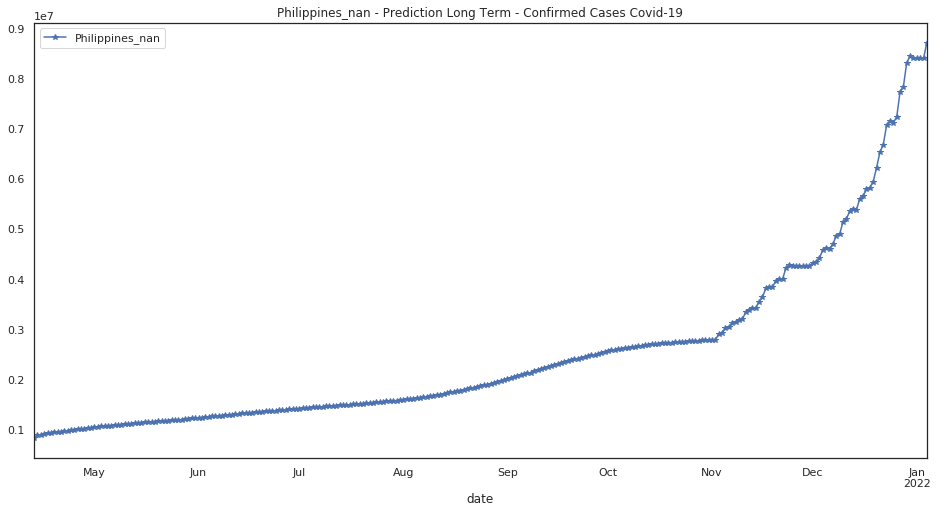

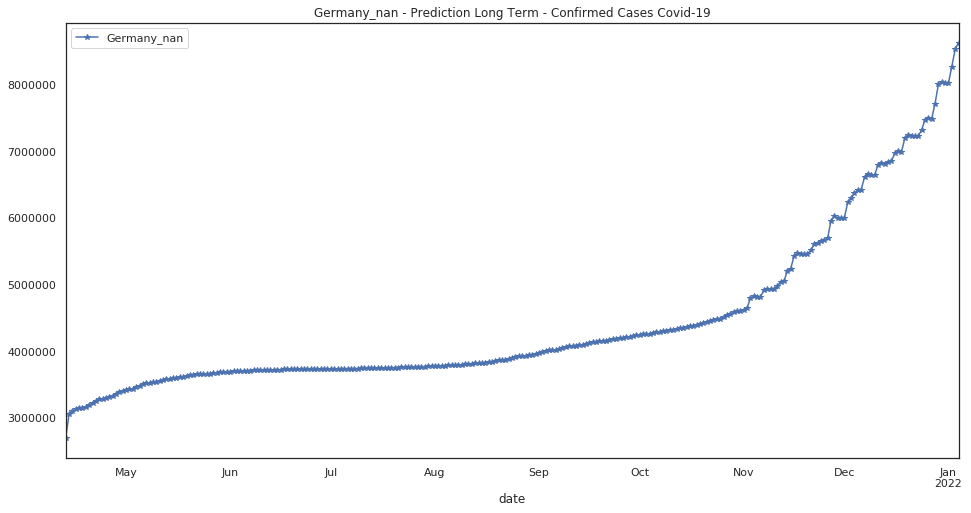

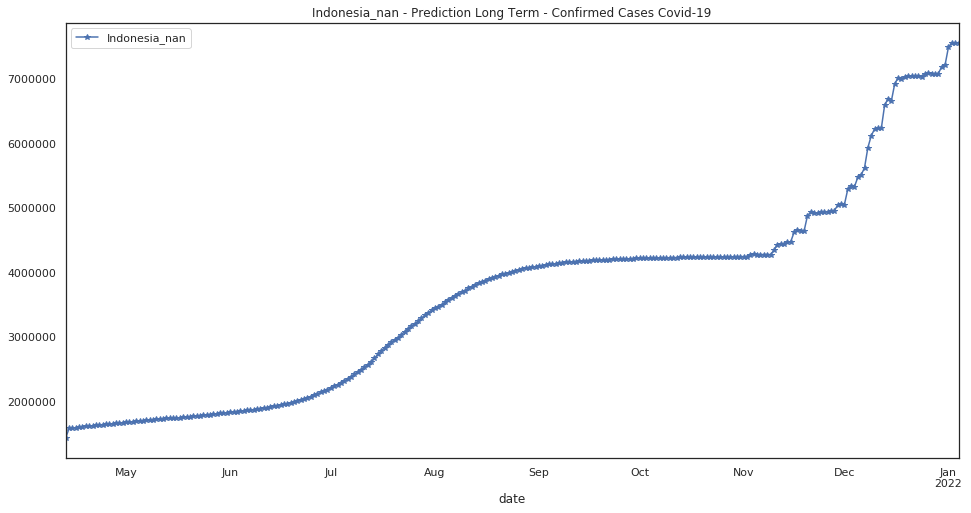

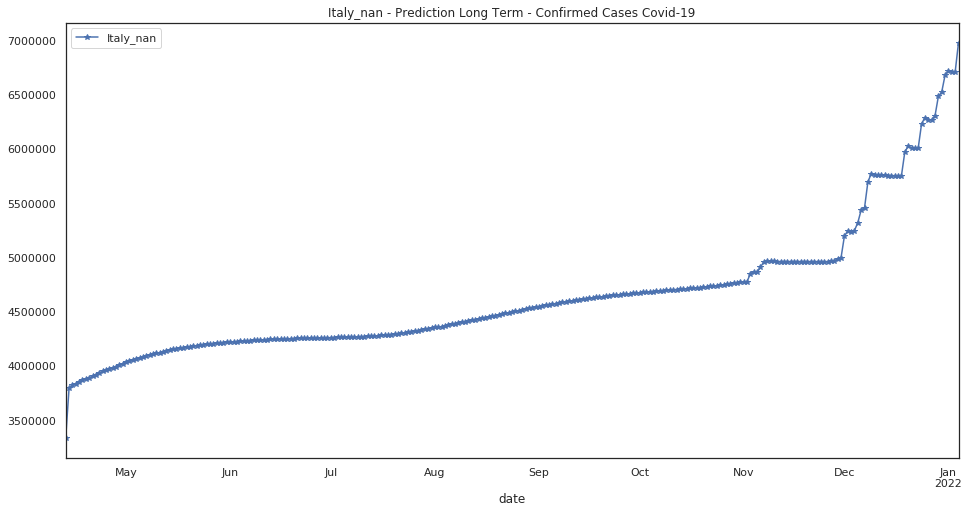

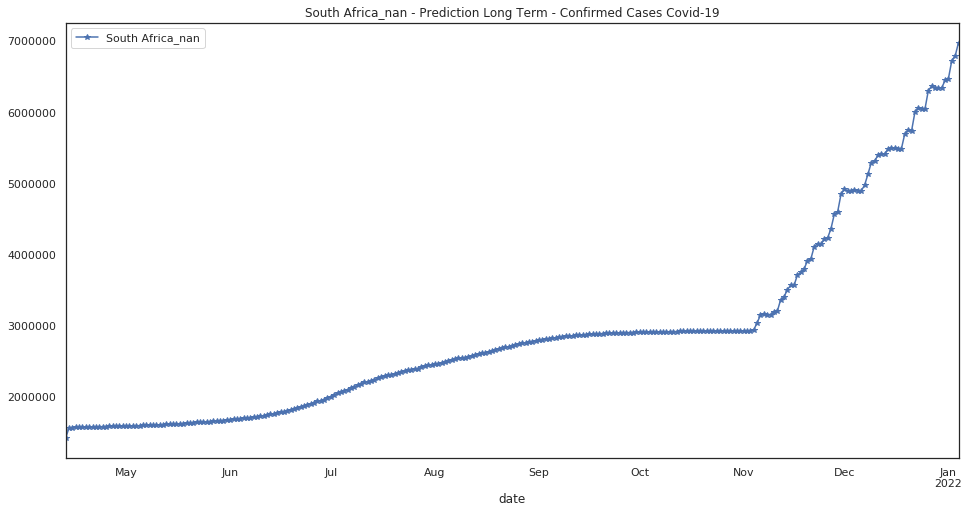

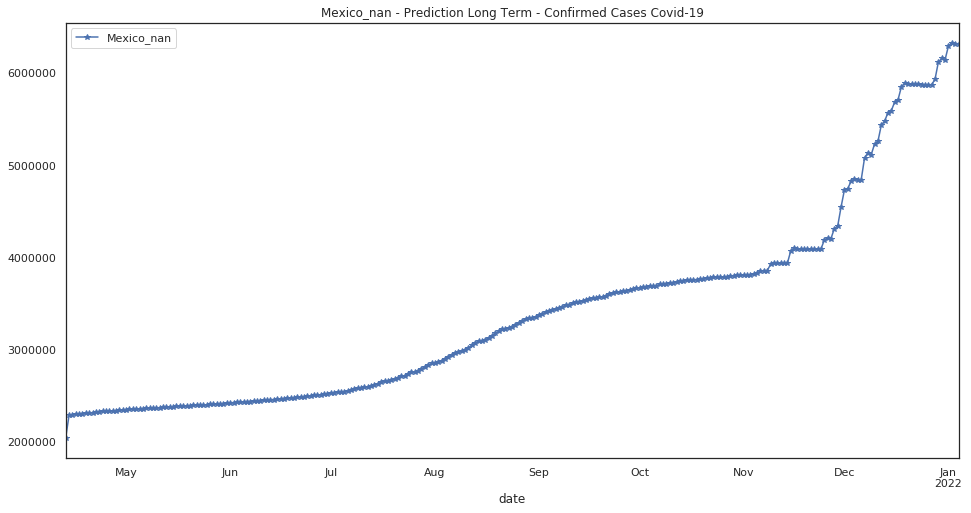

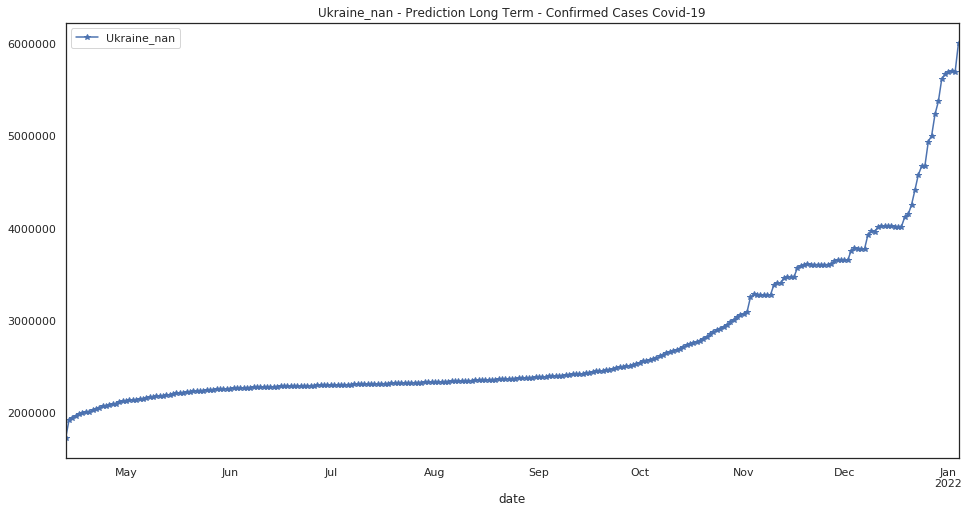

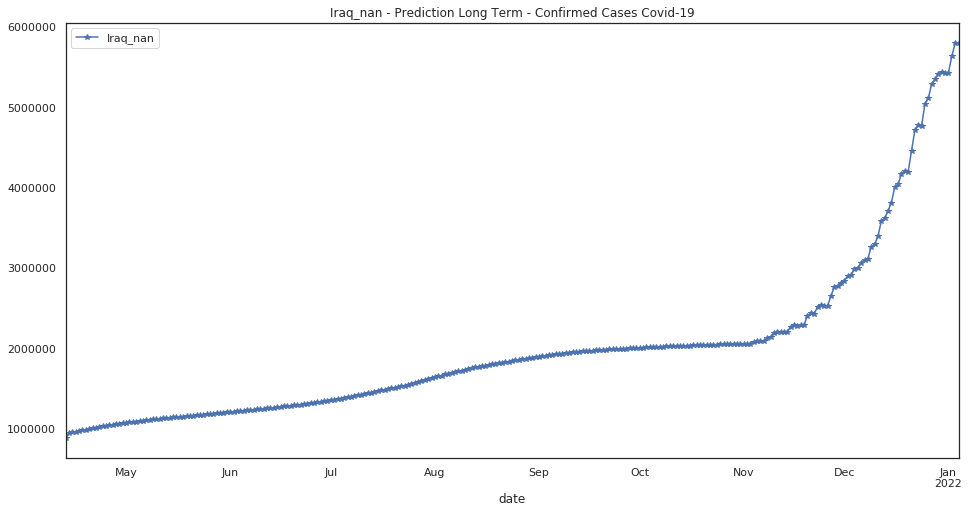

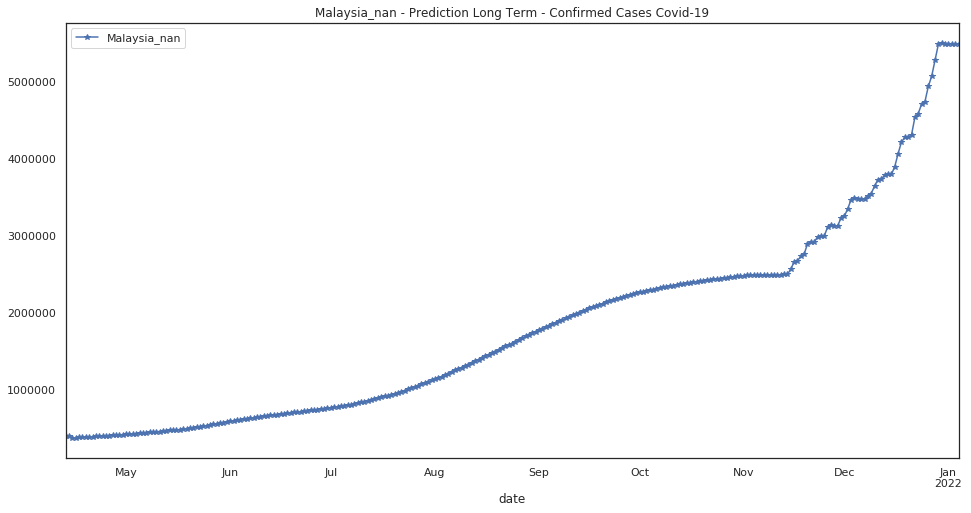

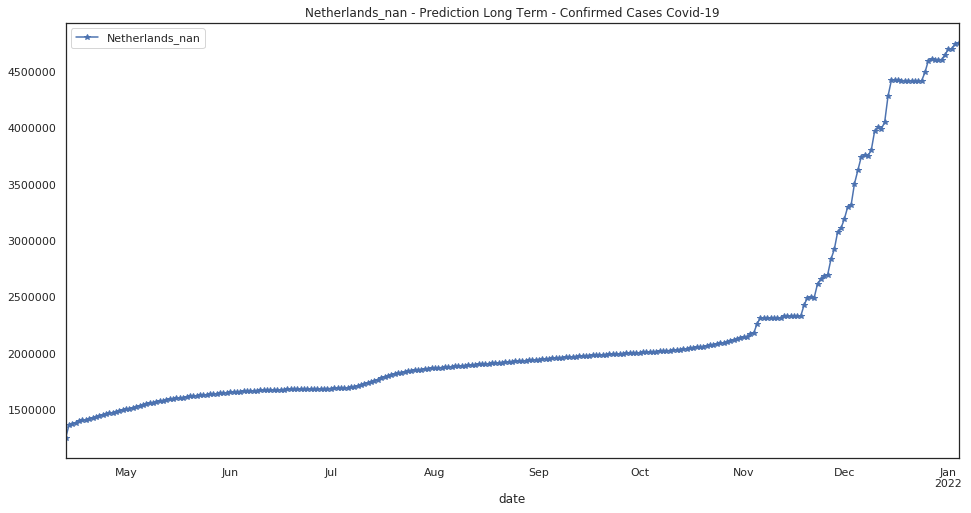

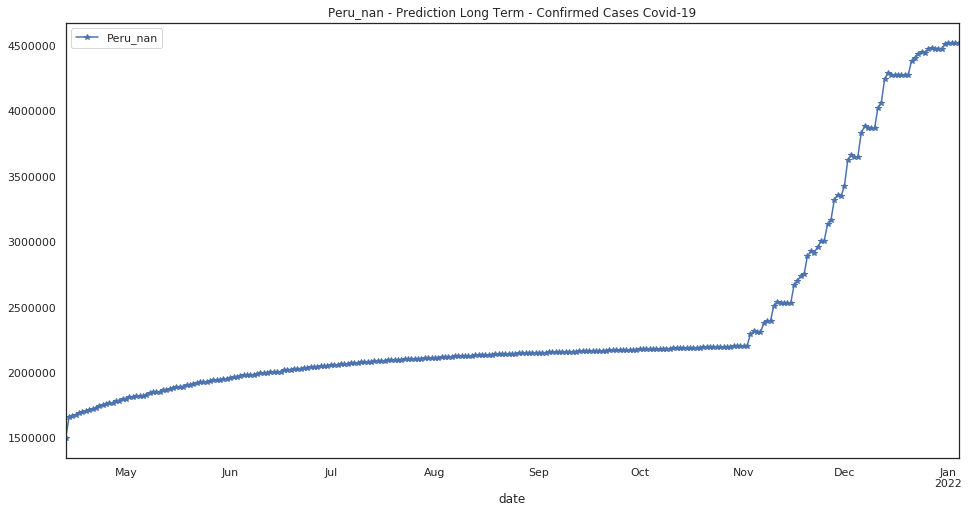

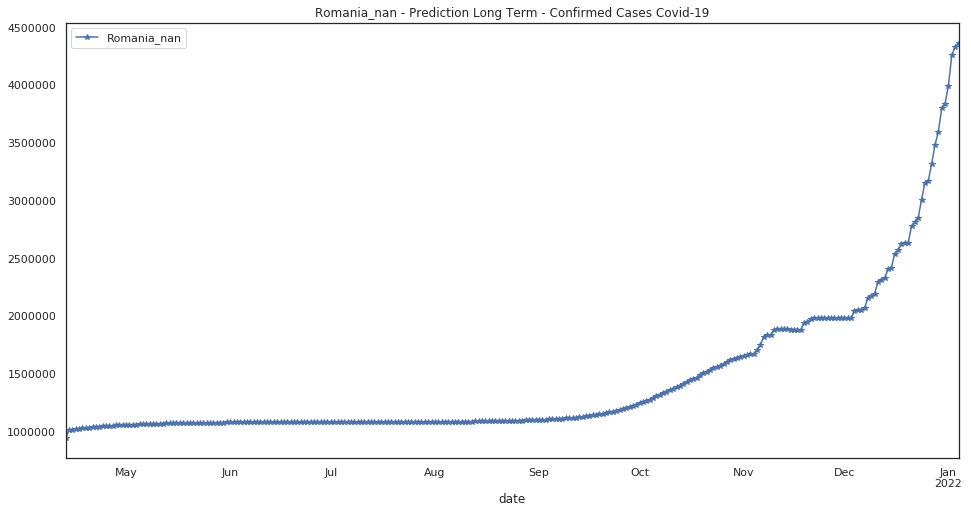

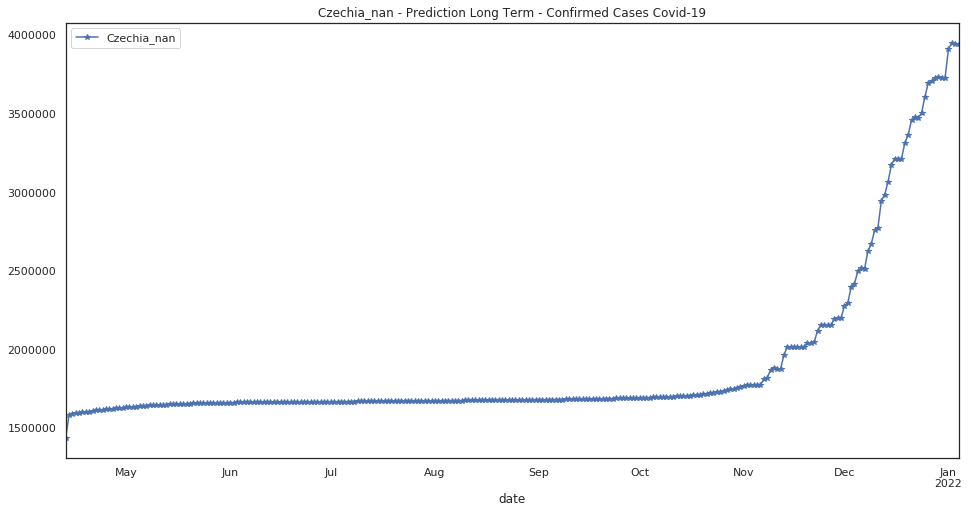

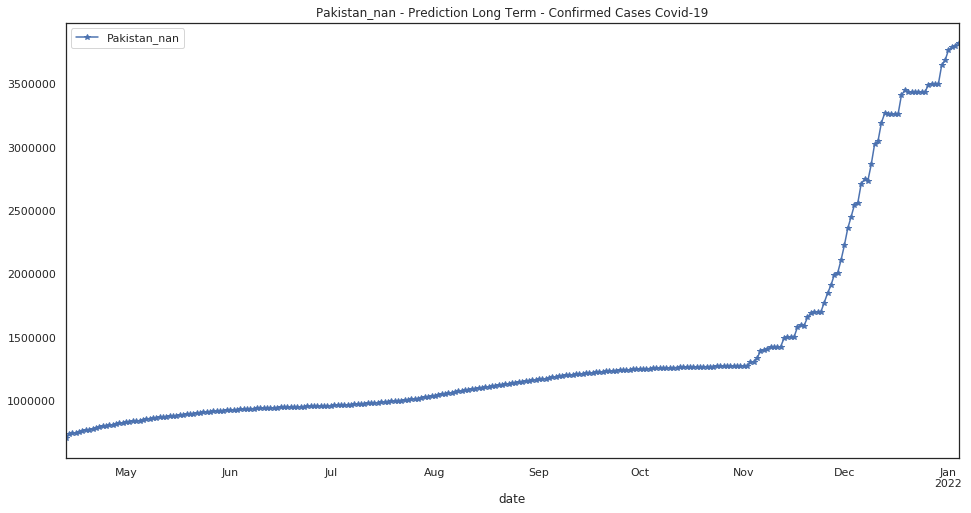

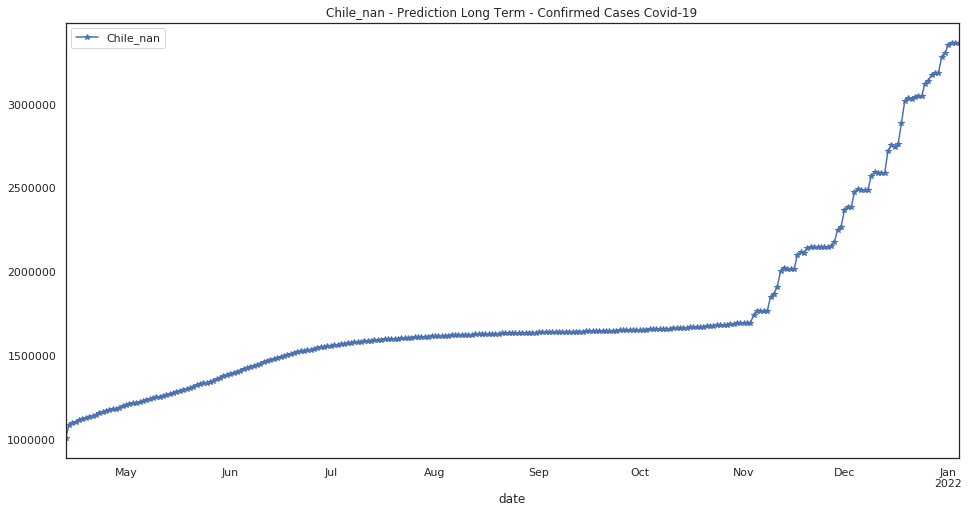

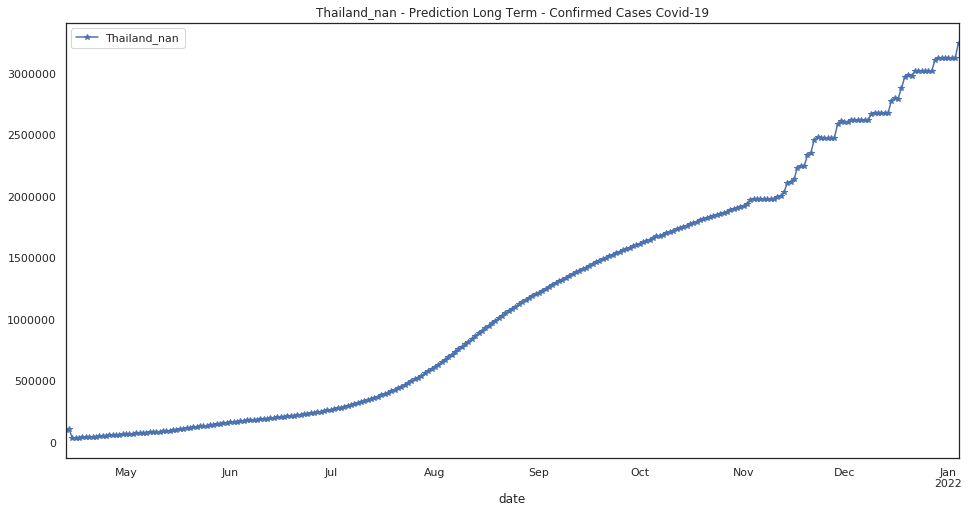

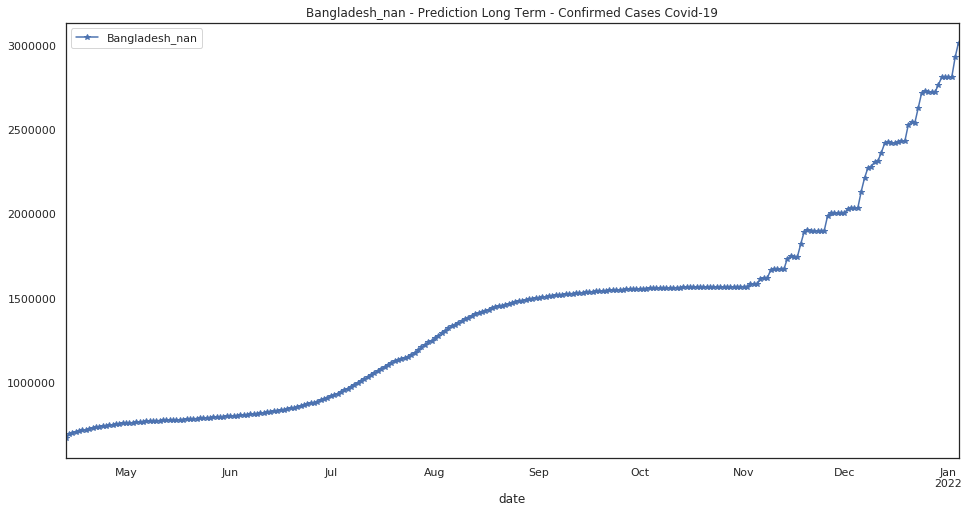

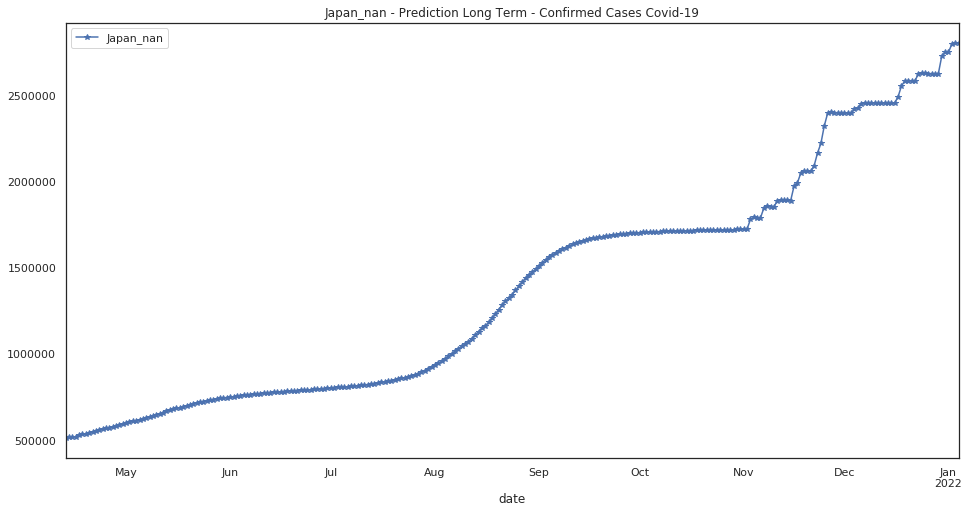

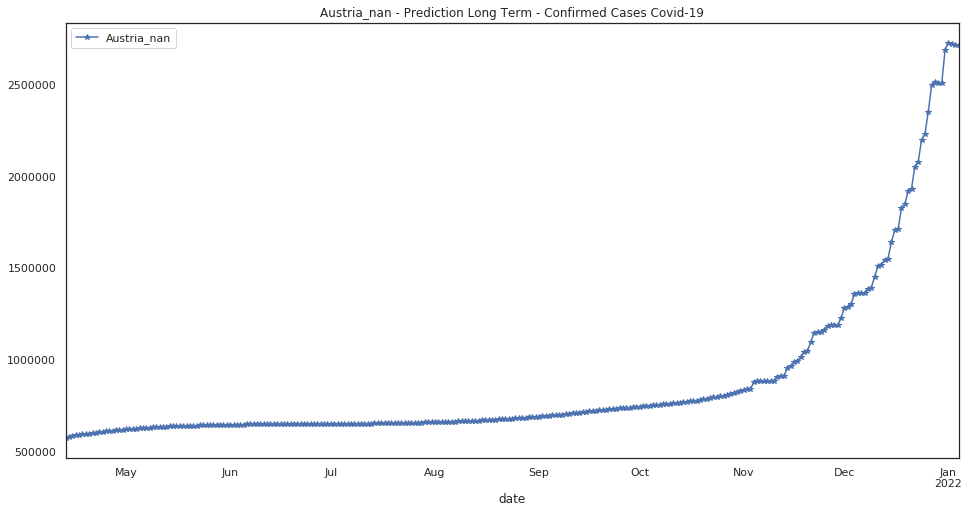

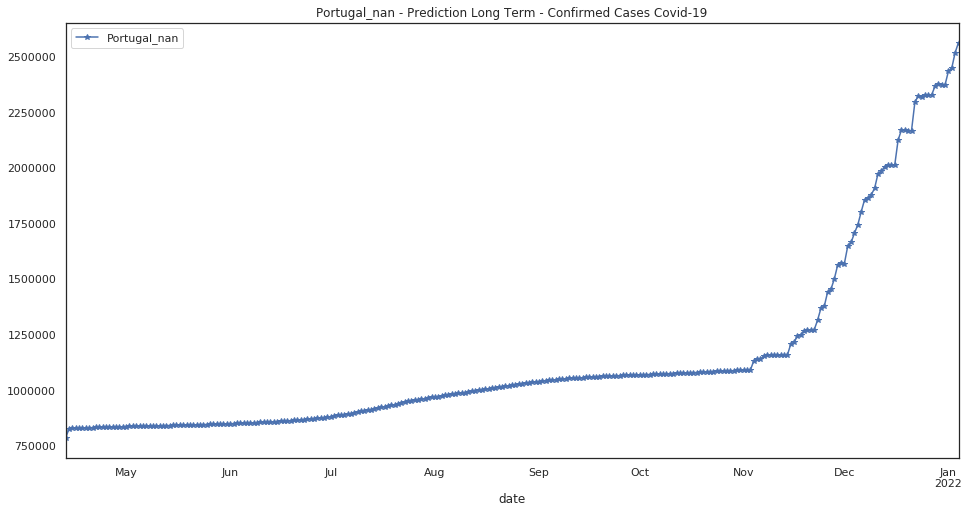

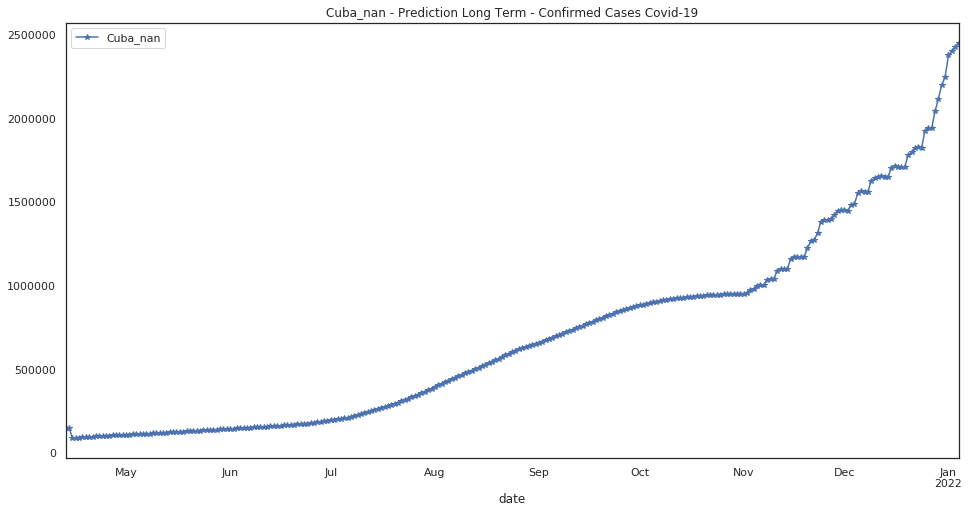

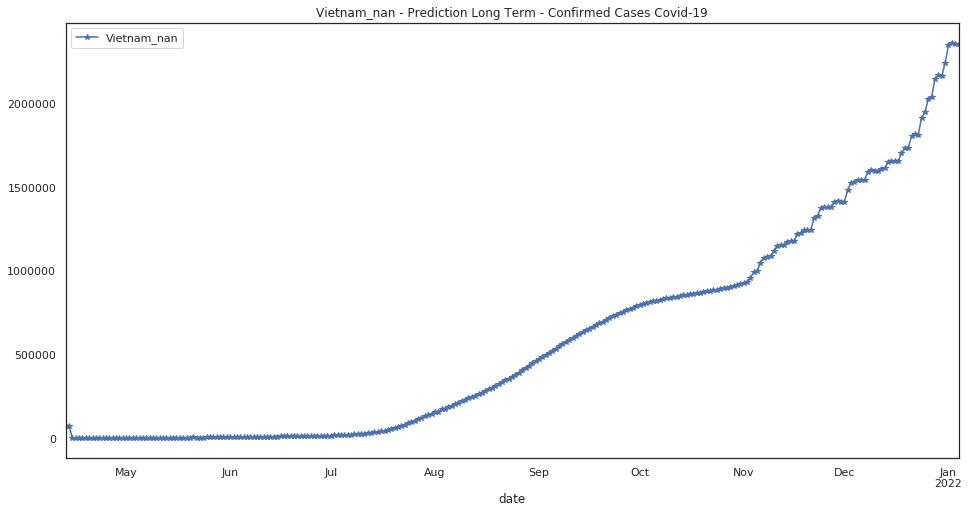

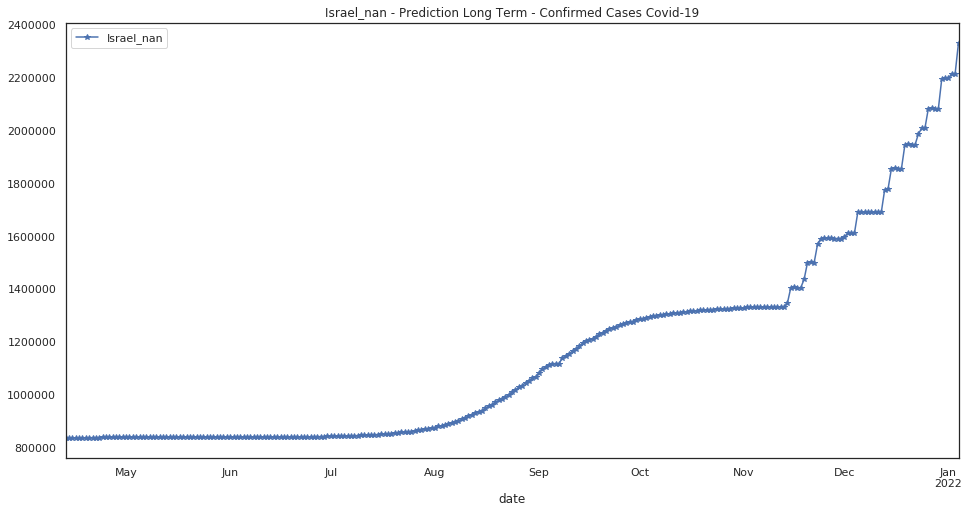

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

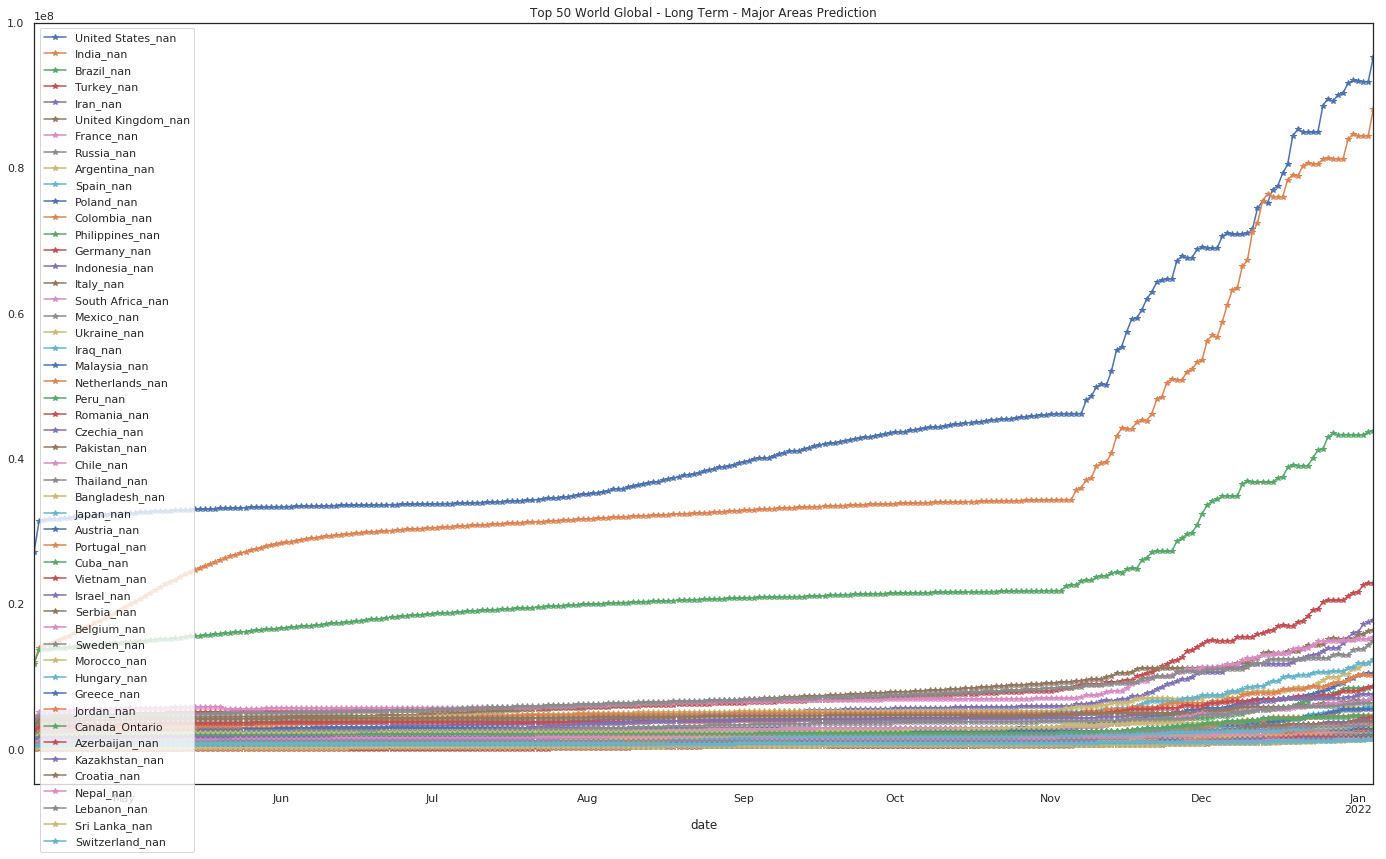

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

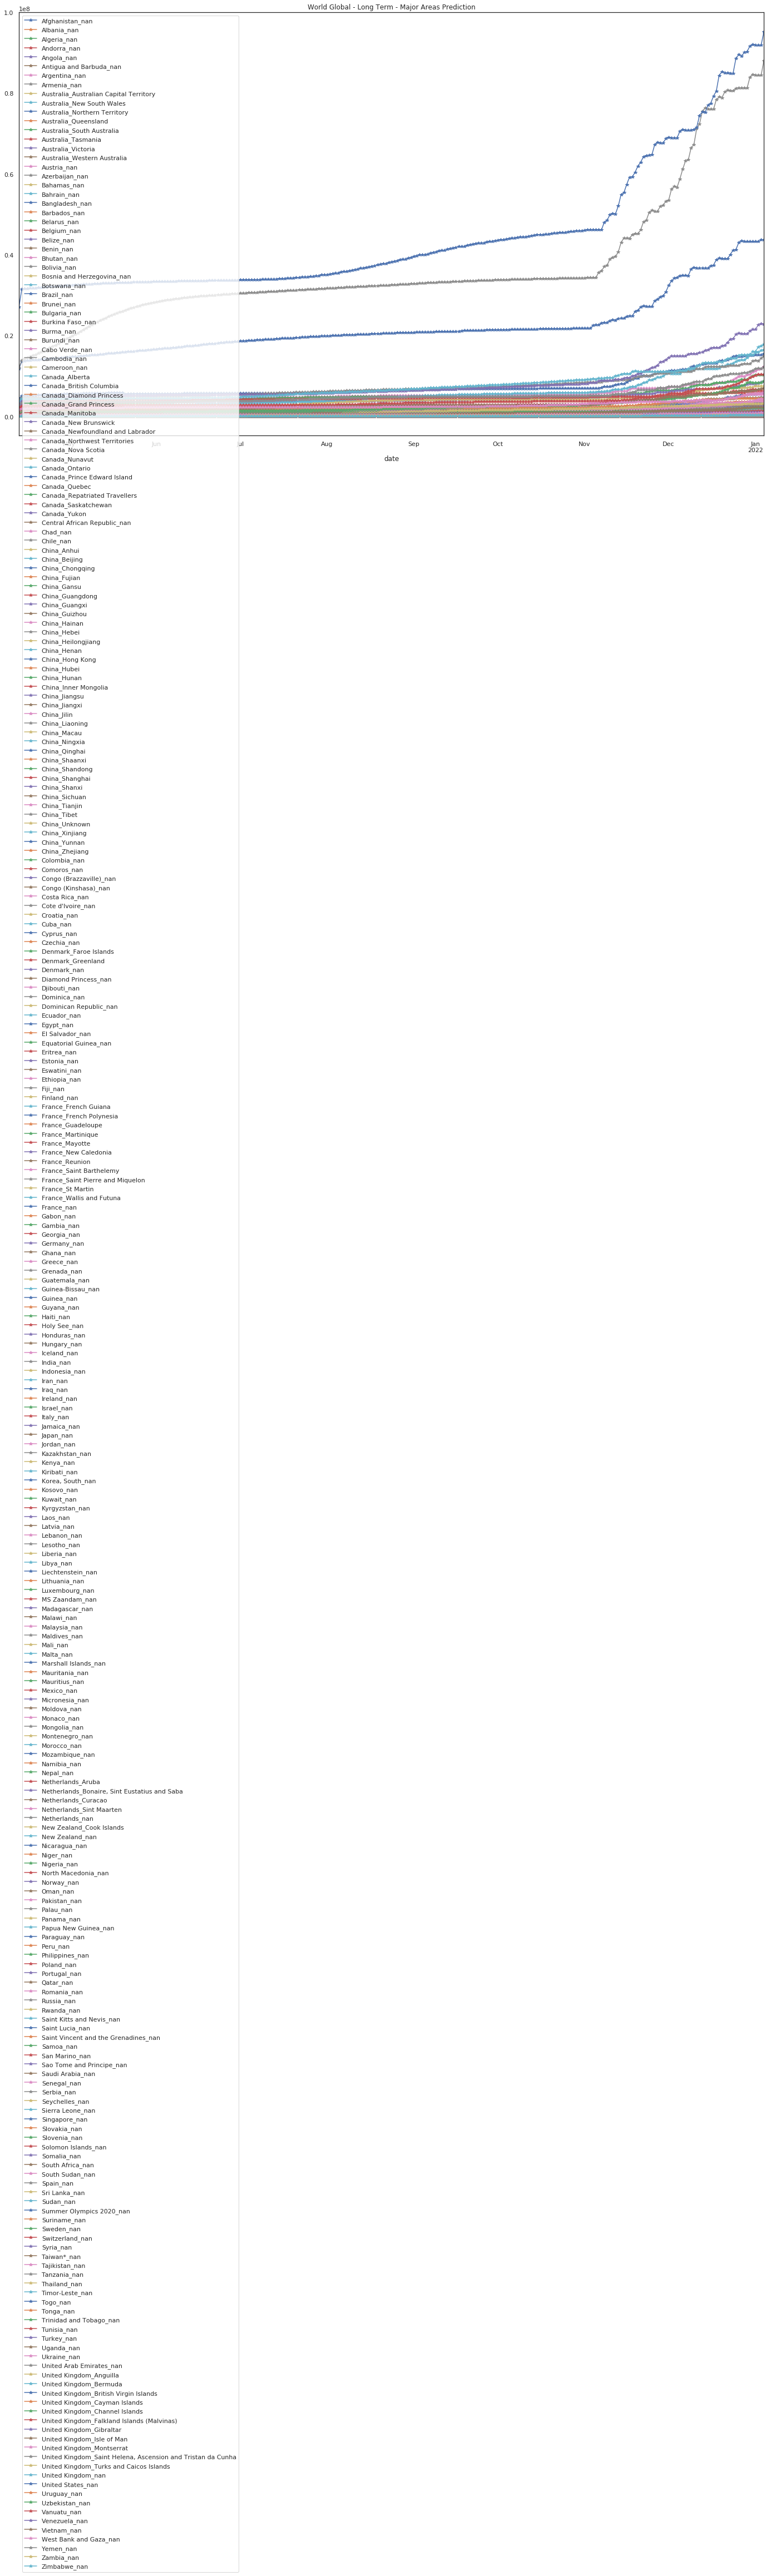

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69776.0     132986.0     129243.0      13682.0   
2021-05-29          70598.0     132999.0     129507.0      13693.0   
2021-05-30          71099.0     133015.0     129782.0      13693.0   
2021-05-31          72478.0     133021.0     129977.0      13693.0   
2021-06-01          73212.0     133044.0     130304.0      13727.0   
2021-06-02          74247.0     133051.0     130652.0      13729.0   
2021-06-03          75461.0     133065.0     130946.0      13744.0   
2021-06-04          76894.0     133079.0     131374.0      13752.0   
2021-06-05          77909.0     133080.0     131682.0      13758.0   
2021-06-06          79388.0     133089.0     131997.0      13758.0   
2021-06-07          81063.0     133093.0     132336.0      13758.0   
2021-06-08          82281.0     133104.0     132671.0      13777.0   
2021-06-09          84127.0     133118.0     133038.0      13781.0   
2021-06-10          85803.0     133127.0     133359.0      13791.0   
2021-06-11          87585.0     133142.0     133757.0      13805.0   
2021-06-12          88785.0     133154.0     134078.0      13813.0   
2021-06-13          90520.0     133164.0     134414.0      13813.0   
2021-06-14          91947.0     133168.0     134776.0      13813.0   
2021-06-15          93358.0     133179.0     135129.0      13826.0   
2021-06-16          93516.0     133183.0     135468.0      13828.0   
2021-06-17          97590.0     133188.0     135859.0      13836.0   
2021-06-18          97624.0     133192.0     136221.0      13839.0   
2021-06-19         100318.0     133197.0     136592.0      13842.0   
2021-06-20         102165.0     133198.0     136853.0      13842.0   
2021-06-21         104306.0     133199.0     137352.0      13842.0   
2021-06-22         105771.0     133205.0     137638.0      13864.0   
2021-06-23         108051.0     133204.0     138054.0      13864.0   
2021-06-24         109575.0     133208.0     138421.0      13873.0   
2021-06-25         111941.0     133214.0     138793.0      13877.0   
2021-06-26         113258.0     133215.0     139130.0      13882.0   
...                     ...          ...          ...          ...   
2021-12-06         203704.0     247362.0     412170.0      22247.0   
2021-12-07         208932.0     252794.0     417689.0      22247.0   
2021-12-08         208645.0     256071.0     437458.0      22254.0   
2021-12-09         209963.0     257002.0     460183.0      22482.0   
2021-12-10         209963.0     256674.0     463822.0      22482.0   
2021-12-11         209860.0     256579.0     466138.0      22482.0   
2021-12-12         215641.0     256579.0     483012.0      23140.0   
2021-12-13         215367.0     259982.0     505703.0      23140.0   
2021-12-14         216786.0     260028.0     535943.0      23140.0   
2021-12-15         222599.0     271482.0     552798.0      23140.0   
2021-12-16         226564.0     273000.0     555887.0      23140.0   
2021-12-17         236226.0     273542.0     556268.0      23784.0   
2021-12-18         237470.0     273542.0     568304.0      23784.0   
2021-12-19         239237.0     286991.0     569633.0      23784.0   
2021-12-20         239467.0     288819.0     579367.0      25159.0   
2021-12-21         239296.0     289494.0     584439.0      25159.0   
2021-12-22         253233.0     301655.0     585078.0      26390.0   
2021-12-23         254026.0     302959.0     595270.0      26390.0   
2021-12-24         257560.0     303559.0     596454.0      27737.0   
2021-12-25         267789.0     303559.0     597034.0      27737.0   
2021-12-26         275459.0     313886.0     604152.0      28624.0   
2021-12-27         277770.0     315144.0     606047.0      28624.0   
2021-12-28         279666.0     326407.0     622292.0      29444.0   
2021-12-29         279510.0     327699.0     624306.0      30875.0   
2021-12-30

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index              region        Lat        Long  2021-04-13 00:00:00  \
0       6       Argentina_nan -38.416100  -63.616700            2291750.0   
1      16         Austria_nan  47.516200   14.550100             573597.0   
2      17      Azerbaijan_nan  40.143100   47.576900             322753.0   
3      20      Bangladesh_nan  23.685000   90.356300             673983.0   
4      23         Belgium_nan  50.833300    4.469936             874046.0   
5      30          Brazil_nan -14.235000  -51.925300           11770352.0   
6      51      Canada_Ontario  51.253800  -85.323200             419424.0   
7      59           Chile_nan -35.675100  -71.543000            1010026.0   
8      94        Colombia_nan   4.570900  -74.297300            2283419.0   
9     100         Croatia_nan  45.100000   15.200000             327288.0   
10    101            Cuba_nan  21.521757  -77.781167             149749.0   
11    103         Czechia_nan  49.817500   15.473000            1436892.0   
12    132          France_nan  46.227600    2.213700            4432873.0   
13    137         Germany_nan  51.165691   10.451526            2700295.0   
14    139          Greece_nan  39.074200   21.824300             332645.0   
15    149         Hungary_nan  47.162500   19.503300             699865.0   
16    151           India_nan  20.593684   78.962880           12005860.0   
17    152       Indonesia_nan  -0.789300  113.921300            1430432.0   
18    153            Iran_nan  32.427908   53.688046            1895449.0   
19    154            Iraq_nan  33.223191   43.679291             883055.0   
20    156          Israel_nan  31.046051   34.851612             836334.0   
21    157          Israel_nan  31.046051   34.851612             836334.0   
22    158           Italy_nan  41.871940   12.567380            3335878.0   
23    160           Japan_nan  36.204824  138.252924             513854.0   
24    161          Jordan_nan  31.240000   36.510000             651712.0   
25    162      Kazakhstan_nan  48.019600   66.923700             355428.0   
26    171         Lebanon_nan  33.854700   35.862300             503568.0   
27    172         Lebanon_nan  33.854700   35.862300             503568.0   
28    182        Malaysia_nan   4.210484  101.975766             386688.0   
29    189          Mexico_nan  23.634500 -102.552800            2040058.0   
30    195         Morocco_nan  31.791700   -7.092600             506253.0   
31    198           Nepal_nan  28.166700   84.250000             315342.0   
32    203     Netherlands_nan  52.132600    5.291300            1246811.0   
33    212        Pakistan_nan  30.375300   69.345100             705322.0   
34    214          Panama_nan   8.538000  -80.782100             382543.0   
35    217            Peru_nan  -9.190000  -75.015200            1501112.0   
36    218     Philippines_nan  12.879721  121.774017             834639.0   
37    219          Poland_nan  51.919400   19.145100            2309682.0   
38    220        Portugal_nan  39.399900   -8.224500             785951.0   
39    222         Romania_nan  45.943200   24.966800             944373.0   
40    223          Russia_nan  61.524010  105.318756            4034592.0   
41    233          Serbia_nan  44.016500   21.005900             631635.0   
42    241    South Africa_nan -30.559500   22.937500            1415325.0   
43    243           Spain_nan  40.463667   -3.749220            2977681.0   
44    244       Sri Lanka_nan   7.873054   80.771797             155920.0   
45    248          Sweden_nan  60.128161   18.643501             827520.0   
46    254        Thailand_nan  15.870032  100.992541             103418.0   
47    260          Turkey_nan  38.963700   35.243300            3481852.0   
48    261   United States_nan  40.000000 -100.000000           27091830.0   
49    263         Ukraine_nan  48.379400   31.165600            1729470.0   
50    276  United Kingdom_nan  55.378100   -3.436000            3837099.0   


In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred, parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()